COME CI COMPORTIAMO CON Z? dividiamo in segmentini da 0.5 z ed eliminiamo la dipendenza

    -dust vs massa (task)
    -sfr vs history (task)
    -sfr vs massa (task) ---> meglio sfr o specific sfr (task)
    -MS dipende da z? (task)

potrebbe anche essere figo vedere:

    -dust vs sfr
    -sfr vs gas_ionizz
    -age_gas vs ion_gas    
    

In [1]:
import matplotlib 
from matplotlib import cm
#permette di aprire le immagini in cartelle a parte, separate dal notebook
#matplotlib.use('Qt5Agg')

#import astropy
import numpy as np
import os
import sep
from pylab import *
import astropy.units as u
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.modeling import models, fitting
from astropy import table
from astropy.table import QTable
from astropy.io import ascii
from astropy.constants import c
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
import matplotlib.tri as tri
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import odr
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde


In [3]:
cavolo = ['sorgente','z', 'TAU','err_TAU', 'AGE', 'err_AGE', 'AV', 'err_AV', 'ALPHA', 
          'err_ALPHA', 'LMASS', 'err_LMASS', 'AGE_GAS', 'err_AGE_GAS', 'ION_GAS', 
          'err_ION_GAS', 'LSFR', 'err_LSFR', 'svincolo']

cavolo_rosso = ['TAU_16','TAU_50','TAU_84','AGE_16','AGE_50','AGE_84','AV_16','AV_50','AV_84',
                'ALPHA_16','ALPHA_50','ALPHA_84','LMASS_16','LMASS_50','LMASS_84',
                'AGE_GAS_16','AGE_GAS_50','AGE_GAS_84','ION_GAS_16','ION_GAS_50','ION_GAS_84',
                'LSFR_16','LSFR_50','LSFR_84', 'uscita']

In [6]:
fit_values = QTable(ascii.read('file:///data1/astlab04/SPS/Fit_values.txt'))
catalogo = fits.open('file:///data1/astlab04/COSMOS_3DHST_MCSPF_input.fits')

In [7]:
fit_values

ID,TAU_16,TAU_50,TAU_84,AGE_16,AGE_50,AGE_84,AV_16,AV_50,AV_84,ALPHA_16,ALPHA_50,ALPHA_84,LMASS_16,LMASS_50,LMASS_84,AGE_GAS_16,AGE_GAS_50,AGE_GAS_84,ION_GAS_16,ION_GAS_50,ION_GAS_84,LSFR_16,LSFR_50,LSFR_84,LNZ,CHI2_PHOT
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
371,442.92,447.728,453.107,1892.926,1901.778,1909.051,0.467,0.473,0.477,3.017,3.093,3.163,10.743,10.745,10.746,0.981,1.065,1.15,-3.493,-3.371,-3.275,0.255,0.255,0.27,1603.581,12.779
445,301.965,307.045,317.999,1407.575,1444.867,1478.448,1.422,1.455,1.493,0.371,0.943,1.536,10.393,10.396,10.399,4.676,7.472,9.127,-3.672,-2.961,-1.763,-0.118,-0.118,-0.064,1337.893,9.964
457,2825.354,3337.143,4181.715,1449.404,1476.193,1511.604,0.085,0.097,0.11,1.322,2.273,3.287,9.346,9.351,9.355,0.505,0.518,0.543,-2.936,-2.913,-2.887,0.083,0.083,0.098,1166.903,29.58
729,4305.109,10473.546,16933.143,297.785,307.471,319.35,1.525,1.53,1.535,0.255,0.645,1.033,9.812,9.818,9.824,0.563,0.736,1.038,-3.668,-3.563,-3.481,1.32,1.32,1.33,1649.736,11.603
779,675.11,682.844,690.707,3136.631,3167.571,3199.269,0.301,0.307,0.313,2.734,3.321,3.7,10.898,10.9,10.901,4.63,4.881,5.035,-3.447,-3.318,-3.173,0.055,0.055,0.065,1062.474,37.742
796,840.959,857.517,880.155,3741.952,3810.156,3887.852,0.845,0.853,0.863,2.77,3.218,3.606,11.321,11.325,11.33,0.562,0.678,0.893,-3.535,-3.467,-3.367,0.471,0.471,0.486,1082.388,36.597
880,1996.88,2136.283,2364.719,2116.874,2219.016,2303.888,0.271,0.293,0.313,0.318,0.775,1.37,9.53,9.542,9.551,4.261,4.571,4.924,-3.911,-3.804,-3.674,-0.046,-0.046,-0.018,1718.589,6.638
937,1083.744,1089.111,1095.615,4719.291,4743.75,4779.976,0.449,0.451,0.454,3.397,3.636,3.848,11.256,11.258,11.26,0.524,0.558,0.622,-3.503,-3.491,-3.464,0.334,0.334,0.339,-2134.1,186.413
1144,13202.754,16753.834,19139.675,3305.027,3646.791,4032.459,0.684,0.714,0.745,0.306,0.743,1.206,9.994,10.013,10.034,0.817,1.323,2.239,-3.634,-3.484,-3.321,0.403,0.403,0.438,1757.221,4.544


In [8]:
t = QTable(np.zeros([1464,19]), names = cavolo)
i = 0
u = 2

while i <= len(cavolo_rosso) and u <= len(cavolo) :
    
    if (cavolo[u] == str('svincolo') and cavolo_rosso[i] == str('uscita')):
        break
            
    t.replace_column(cavolo[u], fit_values[cavolo_rosso[i+1]])
    t.replace_column(cavolo[u+1], (fit_values[cavolo_rosso[i+2]]-fit_values[cavolo_rosso[i]])/2)
    
    u = u +2
    i = i + 3
    

t.replace_column(cavolo[0], fit_values['ID'])
t.replace_column(cavolo[1], catalogo[1].data['z_best'])
t = fits.BinTableHDU(t) #converto la tebella in BinTable
#t.writeto('values_err.fits') #salvo nella cartella di lavoro come file fits

NameError: name 'cavolo' is not defined

In [4]:
dati_completi = fits.open('file:///data1/astlab04/values_err.fits')
tab_data = dati_completi[1].data
qt_tab_data = QTable(tab_data)

Per eliminare la dipendenza dal redshift spezziamo il df in intervalli di z di 0.5

In [5]:
m_s = []
tab = []
tipo = [np.int32, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, 
        np.float64, np.float64, np.float64, np.float64, 
        np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64]
tab_notable = []
estremi = np.array([5, 10, 15, 20, 25, 30])

for i in range(4): #ciclo sulle tabelle che voglio costruire (ciascuna con un intervallo div di z)
     
    for j in range(len(estremi)):
        prova = [] 
        for k in range(len(tab_data)):
            #seleziono gli z in un det intervallo e le salvo dentro "prova" (riga per riga) 
            if tab_data['z'][k] > estremi[j]*0.1 and tab_data['z'][k] <= estremi[j+1]*0.1:
                prova.append(tab_data[k]) #aggiungo righe selezionate in una variabile temporanea
                
        prova = np.array(prova) #adesso tabella diversa con le specifiche z
        #j = j + 2 #passo all'intervallo di z successivo
        
        m_s.append(prova) #metto tutte le tabelle selezionate in un unica lista
           
    tab.append(QTable(np.array(m_s[i]), names = cavolo, dtype = tipo)) #trasformo in QTable perchè più leggibile
    tab_notable.append(np.array(m_s[i]))   
    
for i in range (len(tab)):
    tab[i].remove_column('svincolo')  
    

siccome vogliamo fare un fit lineare dobbiamo sostituire gli errori pari a zero se no mi fanno divergere il chi quadro

In [6]:
#RICORDA che tab è un vettore di matrici facendo tab[i] accedo ai diversi intervalli di redshift che abbiamo 
#selezionato le celle sopra

df = tab
errori = ['err_LMASS', 'err_LSFR', 'err_TAU', 'err_AV', 'err_ALPHA', 'err_AGE_GAS', 'err_ION_GAS', 'err_AGE' ]
for i in range(len(tab)):
    for j in range(len(tab[i])):
        for k in errori:
            if df[i][k][j] == 0.: #sostituisco 0 con
                df[i][k][j] = 0.0001 #un valore molto piccolo a caso tipo questo, basta che non sia zero
        

In [7]:
########### VEDIAMO LA DIPENDENZA TRA MASSA E STAR FORMATION ###########

In [8]:
title = []

for j in range(len(estremi)):
    if j == (len(estremi)-1):
        break
    title.append(str(estremi[j]/10)+'<z<'+str((estremi[j+1])/10))
    

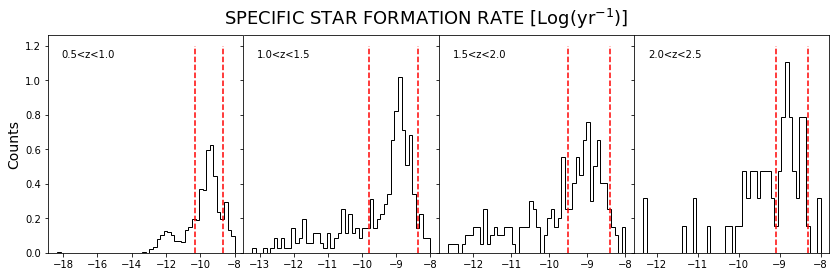

In [9]:
fig1 = plt.figure( figsize = (14,4) )

plt.suptitle(r'SPECIFIC STAR FORMATION RATE [Log(yr$^{-1}$)]', fontsize = 18 )

ax0 = plt.subplot(1,4,1)
plt.text(0.07,.9,title[0], transform=ax0.transAxes)
plt.hist(df[0]['LSFR']-df[0]['LMASS'], bins = 50, density = True, histtype = 'step', color = 'black')
plt.vlines(-10.3, 0,1.2, ls='--', color= 'r')
plt.vlines(-8.7, 0,1.2, ls='--', color= 'r')
plt.ylabel('Counts', fontsize = 14)


ax = plt.subplot(1,4,2)
plt.text(0.07,.9,title[1], transform=ax.transAxes)
plt.hist(df[1]['LSFR']-df[1]['LMASS'], bins = 50, density = True, histtype = 'step', color = 'black')
plt.vlines(-9.8, 0,1.2, ls='--', color= 'r')
plt.vlines(-8.35, 0,1.2, ls='--', color= 'r')
ax.set_yticklabels([])
#plt.xlim(-14, -7.8)


ax1 = plt.subplot(1,4,3)
plt.text(0.07,.9,title[2], transform=ax1.transAxes)
plt.hist(df[2]['LSFR']-df[2]['LMASS'], bins = 50, density = True, histtype = 'step', color = 'black')
plt.vlines(-9.5, 0,1.2, ls='--', color= 'r')
plt.vlines(-8.4, 0,1.2, ls='--', color= 'r')
ax1.set_yticklabels([])


ax2 = plt.subplot(1,4,4)
plt.text(0.07,.9,title[3], transform=ax2.transAxes)
plt.hist(df[3]['LSFR']-df[3]['LMASS'], bins = 50, density = True, histtype = 'step', color = 'black')
plt.vlines(-9.1, 0,1.2, ls='--', color='r')
plt.vlines(-8.3, 0,1.2, ls='--', color='r')
ax2.set_yticklabels([])


plt.subplots_adjust(wspace = 0)
#fig1.savefig('sSFR_hist.png')

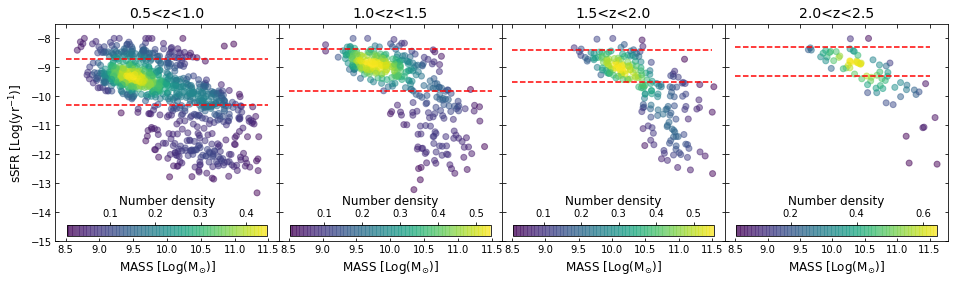

In [10]:


fig = plt.figure(figsize = (16,4))


for i in range (len(tab)):
    
    xy = np.vstack([df[i]['LMASS'],df[i]['LSFR']-df[i]['LMASS']])
    z=gaussian_kde(xy)(xy)
    
    ax = plt.subplot(1,4,i+1)
    #SPECIFIC SFR SIAMO CON LE POTENZE!! per normalizzare devo sottrarre gli esponenti
    quercia = plt.scatter(df[i]['LMASS'], df[i]['LSFR']-df[i]['LMASS'], alpha = 0.5, c = z)
    axin = inset_axes(ax, width = "90%", height = "5%", loc = 'lower center')
    c_bar = fig.colorbar(quercia, cax=axin, orientation = 'horizontal')
    axin.xaxis.set_ticks_position("top")
    axin.xaxis.set_label_text('Number density', fontsize = 12)
    axin.xaxis.set_label_position('top')
    
    #axin.set_title
    
    if i == 0:
        ax.hlines(-10.3, 8.5,11.5,ls = '--', color= 'r') #0.5<z<1.
        ax.hlines(-8.7, 8.5,11.5, ls ='--', color= 'r')
        ax.set_ylabel('sSFR [Log(yr$^{-1}$)]', fontsize = 12)
        
    elif i == 1:
        ax.hlines(-9.8, 8.5,11.5, ls ='--', color= 'r') #1.<z<1.5
        ax.hlines(-8.35, 8.5,11.5, ls ='--', color= 'r')
        ax.set_yticklabels([])
    
    elif i == 2:
        ax.hlines(-9.5, 8.5,11.5, ls ='--', color= 'r') #1.5<z<2.
        ax.hlines(-8.4, 8.5,11.5, ls ='--', color= 'r')
        ax.set_yticklabels([])
   
    elif i == 3:
        ax.hlines(-9.3, 8.5,11.5, ls ='--', color= 'r') #2.<z<2.5
        ax.hlines(-8.3, 8.5,11.5, ls ='--', color= 'r')
        ax.set_yticklabels([])

    ax.set_xlabel(r'MASS [Log(M$_{\odot}$)]', fontsize = 12)
    ax.set_title(title[i], fontsize = 14)
    ax.set_ylim(-15,-7.5)
    
    ax.tick_params(axis='x',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax.tick_params(axis='y',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')

plt.subplots_adjust(wspace = 0)    
#plt.savefig('numb_density.png')
plt.show()
plt.close()
    

dobbiamo tagliare tutti i dati che abbiamo sopra tenendoci solo le galassie che hanno una star formation specifica utile (>-10.5) e ragionare sul resto dei punti. Ignoro le galassie che non hanno SFR perchè non riproduco la mia ZAMS

Facciamo un ragionamento simile usando curve di livello a densità costante

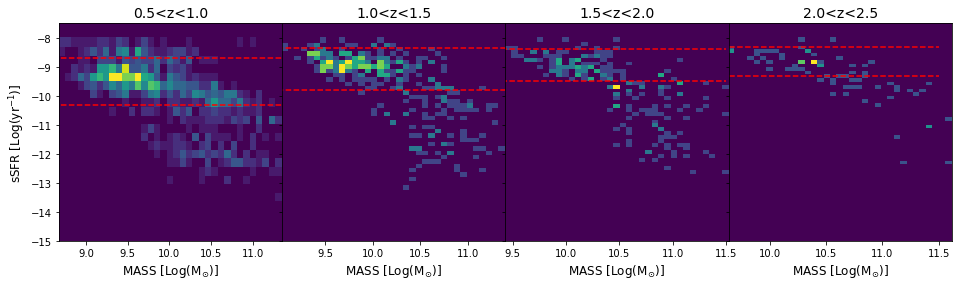

In [11]:


fig = plt.figure(figsize = (16,4))


for i in range (len(tab)):
    
    xy = np.vstack([df[i]['LMASS'],df[i]['LSFR']-df[i]['LMASS']])
    z=gaussian_kde(xy)(xy)
    
    ax = plt.subplot(1,4,i+1)
    #SPECIFIC SFR SIAMO CON LE POTENZE!! per normalizzare devo sottrarre gli esponenti
    quercia = plt.hist2d(df[i]['LMASS'], df[i]['LSFR']-df[i]['LMASS'], bins=35, cmap = 'viridis')
    plt.gca().patch.set_color('#440154FF')
    #axin = inset_axes(ax, width = "90%", height = "5%", loc = 'lower center')
    #c_bar = fig.colorbar(quercia, cax=axin, orientation = 'horizontal')
    #axin.xaxis.set_ticks_position("top")
    #axin.xaxis.set_label_text('Number density', fontsize = 12)
    #axin.xaxis.set_label_position('top')
    
    #axin.set_title
    
    if i == 0:
        ax.hlines(-10.3, 8.5,11.5,ls = '--', color= 'r') #0.5<z<1.
        ax.hlines(-8.7, 8.5,11.5, ls ='--', color= 'r')
        ax.set_ylabel('sSFR [Log(yr$^{-1}$)]', fontsize = 12)
        
    elif i == 1:
        ax.hlines(-9.8, 8.5,11.5, ls ='--', color= 'r') #1.<z<1.5
        ax.hlines(-8.35, 8.5,11.5, ls ='--', color= 'r')
        ax.set_yticklabels([])
    
    elif i == 2:
        ax.hlines(-9.5, 8.5,11.5, ls ='--', color= 'r') #1.5<z<2.
        ax.hlines(-8.4, 8.5,11.5, ls ='--', color= 'r')
        ax.set_yticklabels([])
   
    elif i == 3:
        ax.hlines(-9.3, 8.5,11.5, ls ='--', color= 'r') #2.<z<2.5
        ax.hlines(-8.3, 8.5,11.5, ls ='--', color= 'r')
        ax.set_yticklabels([])

    ax.set_xlabel(r'MASS [Log(M$_{\odot}$)]', fontsize = 12)
    ax.set_title(title[i], fontsize = 14)
    ax.set_ylim(-15,-7.5)
    

plt.subplots_adjust(wspace = 0)    
#plt.savefig('numb_density_hist2d.png')
plt.show()
plt.close()
    

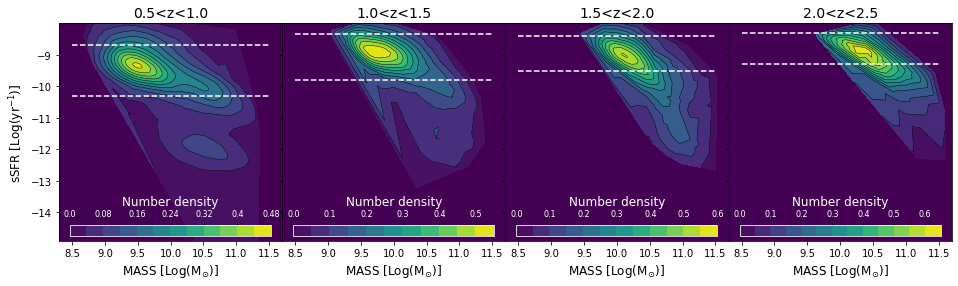

In [12]:
bounds = [0.1, 0.2, 0.3, 0.4]

fig = plt.figure(figsize = (16,4))

for i in range (len(tab)):
    a = df[i]['LMASS']
    b = df[i]['LSFR']-a

    xy = np.vstack([df[i]['LMASS'],df[i]['LSFR']-df[i]['LMASS']])
    z=gaussian_kde(xy)(xy)


    ngridx = 500
    ngridy = 500
    xi = np.linspace(min(a), max(a), ngridx)
    yi = np.linspace(min(b), max(b), ngridy)

    # Perform linear interpolation of the data (x,y)
    # on a grid defined by (xi,yi)
    triang = tri.Triangulation(a, b)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    ax = plt.subplot(1,4,i+1)
    plt.gca().patch.set_color('#440154FF')
    plt.contour(xi, yi, zi, levels=12, linewidths=0.5, colors='black', corner_mask = True)
    cntr1 = plt.contourf(xi, yi, zi, levels=12, cmap="viridis")
    

   
    if i == 0:
        plt.hlines(-10.3, 8.5,11.5,ls = '--', color= 'w') #0.5<z<1.
        plt.hlines(-8.70, 8.5,11.5, ls ='--', color= 'w')
        ax.set_ylabel('sSFR [Log(yr$^{-1}$)]', fontsize = 12)
        
    elif i == 1:
        plt.hlines(-9.80, 8.5,11.5, ls ='--', color= 'w') #1.<z<1.5
        plt.hlines(-8.35, 8.5,11.5, ls ='--', color= 'w')
        ax.set_yticklabels([])
    
    elif i == 2:
        plt.hlines(-9.5, 8.5,11.5, ls ='--', color= 'w') #1.5<z<2.
        plt.hlines(-8.4, 8.5,11.5, ls ='--', color= 'w')
        ax.set_yticklabels([])
   
    elif i == 3:
        plt.hlines(-9.3, 8.5,11.5, ls ='--', color= 'w') #2.<z<2.5
        plt.hlines(-8.3, 8.5,11.5, ls ='--', color= 'w')
        ax.set_yticklabels([])
    
    plt.title(title[i], fontsize = 14)
    plt.ylim(-14.9,max(b))
    plt.xlabel(r'MASS [Log(M$_{\odot}$)]', fontsize = 12)
    plt.xlim(8.3,11.7)

    
    axin = inset_axes(ax, width = "90%", height = "5%", loc = 'lower center')
    c_bar = fig.colorbar(cntr1, cax=axin, orientation = 'horizontal', drawedges = True)
    c_bar.outline.set_edgecolor('w')
    c_bar.dividers.set_linewidth(0.00000000000001)
    targhette = c_bar.get_ticks()
    for i in range(len(targhette)):
        targhette[i] = round(targhette[i],2)
    #print(targhette)
    axin.xaxis.set_label_text('Number density', fontsize = 12, c = 'white')
    axin.xaxis.set_label_position('top')
    axin.xaxis.set_ticks_position('top')
    axin.xaxis.set_ticklabels(ticklabels = targhette , fontsize = 8, color = 'w')
        
plt.subplots_adjust(wspace = 0)
#plt.savefig('numb_density_contour_12lv.png')

Per selezionare i dati guardo i conteggi per la SFR con un isotgramma

In [13]:
#seleziono i dati che mi interessano 
n_t = []

for j in range(len(df[0])):

    if (df[0]['LSFR'][j]-df[0]['LMASS'][j]) >= -10.3 and (df[0]['LSFR'][j]-df[0]['LMASS'][j]) <= -8.7:
        n_t.append(np.array(df[0][j]))
        
for j in range(len(df[1])):
    if (df[1]['LSFR'][j]-df[1]['LMASS'][j]) >= -9.8 and (df[1]['LSFR'][j]-df[1]['LMASS'][j]) <= -8.35:
        n_t.append(np.array(df[1][j]))

for j in range(len(df[2])):
    if (df[2]['LSFR'][j]-df[2]['LMASS'][j]) >= -9.5 and (df[2]['LSFR'][j]-df[2]['LMASS'][j]) <= -8.4:
        n_t.append(np.array(df[2][j]))

for j in range(len(df[3])):
    if (df[3]['LSFR'][j]-df[3]['LMASS'][j]) >= -9.1 and (df[3]['LSFR'][j]-df[3]['LMASS'][j]) <= -8.3:
        n_t.append(np.array(df[3][j]))


#non posso rendere n_t un array e fare quello che ho fatto poche celle fa perchè il mio dataframe non è 
#un fits come tab_data. Adesso n_t è una lista 
nn_t = np.array(n_t)       
#è una tabellona con i dati tagliato come serve a noi, però non è più suddivisa negli intervalli di z

#per non renderci la vita troppo difficile rifacciamo quello che abbiamo fatto prima per dividere, solo che ora
#lo faccio con nn_t al posto che con tab_data (tanto fits e array funziano più o meno isshtess)

n_m_s = []
n_tab = []

for i in range(len(tab)): #ciclo sulle tabelle che voglio costruire (ciascuna con un intervallo div di z)
     
    for j in range(len(estremi)):
        prova = [] 
        for k in range(len(nn_t)):
            #seleziono gli z in un det intervallo e le salvo dentro "prova" (riga per riga) 
            if nn_t['z'][k] > estremi[j]*0.1 and nn_t['z'][k] <= estremi[j+1]*0.1:
                prova.append(nn_t[k]) #aggiungo righe selezionate in una variabile temporanea
                
        prova = np.array(prova) #adesso tabella diversa con le specifiche z
        #j = j + 2 #passo all'intervallo di z successivo
        
        n_m_s.append(prova) #metto tutte le tabelle selezionate in un unica lista
           
    n_tab.append(QTable(np.array(n_m_s[i]))) #che trasformo in QTable perchè più leggibile
                
    
    #n_tab_fits = fits.BinTableHDU(n_tab[i]) #converto la tebella in BinTable
    #n_tab_fits.writeto('testata'+str(i)+'.fits') 
    #salvo nella cartella di lavoro come file fits#sostituisco gli errori == 0 con qualcosa di moolto piccolo

    #RICORDA che tab è un vettore di matrici facendo tab[i] accedo ai diversi intervalli di redshift che abbiamo 
#selezionato le celle sopra

sfr vs mass. Ci aspetteremmo di vedere (almeno un fit sublineare) la pendenza diminuire all'aumentare del redshift. Siccome dal grafico abbiamo osservato una regione più densamente popolata, abbiamo eliminato le galassie quiescenti e fatto fit lineare con i nostri errori. Siccome vengono i risultati che si vedono sopra abbiamo pensato di eliminare sia le galassie con poca sfr che quelle con una formazione più elevata della media, isolando così ma ZAMS. Facendo il fit lineare con gli errori da noi calcolati escono andamenti leggermente migliori ma comunque non compare un legame con il redshift (controllato tutto sia con SFR che con Specific SFR). Dobbiamo scremare in qualche modo i dati? come trattiamo gli errori? non va bene il fit? oh mama aim gonna crai

Pensiamo che la causa di questo errore nel fare il fit sia legata al modo in cui gli specifichiamo gli errori. Proviamo quindi a modificarli.

slope0= 0.5982411266865679
slope1= 0.6005894550843894
slope2= 0.6188069324461226
slope3= 0.6144466606056053


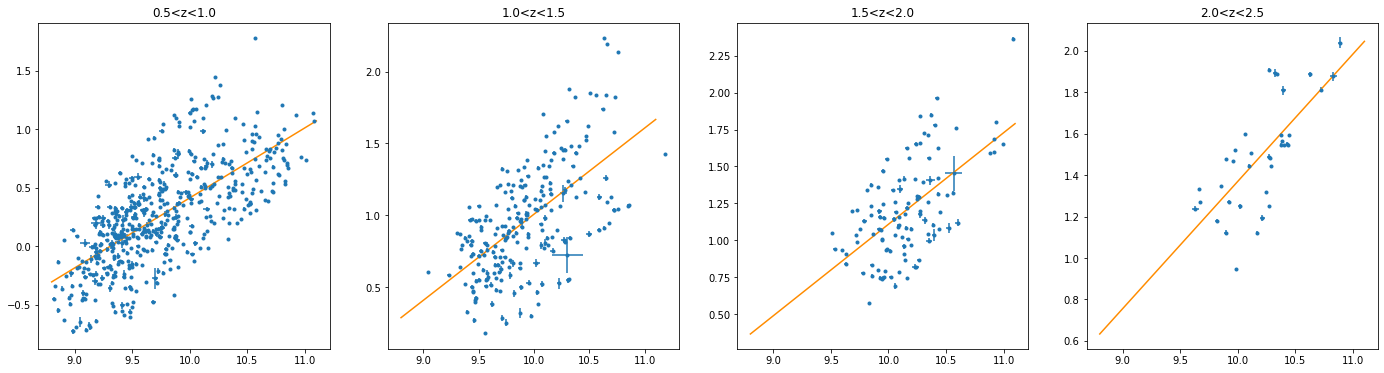

In [14]:
###FITTO PER VEDERE LA MAIN SEQUENCE

def lineare(p,x):
    m, q = p
    y = m*x + q
    return y

slope = []
plt.figure( figsize = (24, 6))
#SFR vs MASSA 
for i in range(len(n_tab)):
    
    plt.subplot(1,4,i+1)
    quad_model1 = odr.Model(lineare)
    data1 = odr.RealData(n_tab[i]['LMASS'], 
                         n_tab[i]['LSFR'],
                         sx =  1,   #non sappiamo come mettere gli errori, 
                         sy = 1/np.var(n_tab[i]['LSFR']) )    #se usare i nostri oppure no
                        
    odr1 = odr.ODR(data1, quad_model1, beta0 = [0.63625473, -6.15919031])  
    out1 = odr1.run()
    
    slope.append(out1.beta)
    
    print('slope'+str(i)+'=',out1.beta[0])
    
    
    
    plt.errorbar(n_tab[i]['LMASS'], 
                 n_tab[i]['LSFR'],
                 xerr = n_tab[i]['err_LMASS'], 
                 yerr = n_tab[i]['err_LSFR'], fmt='.')
    x = np.linspace(8.8, 11.1,10)
    y = out1.beta[0]*x+out1.beta[1]

    plt.title(title[i])
    plt.plot(x,y, c = 'darkorange')

plt.show()
    


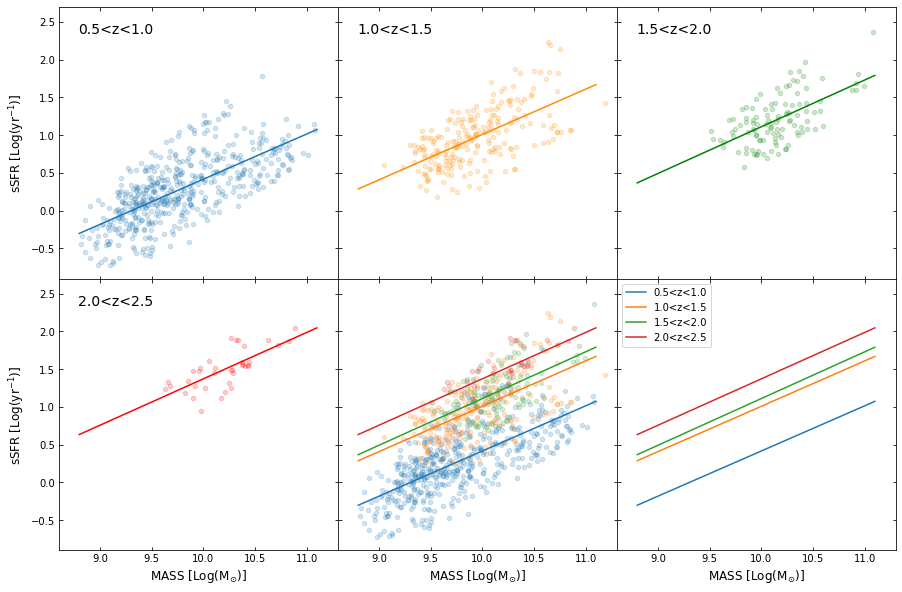

In [15]:
###FITTO PER VEDERE LA MAIN SEQUENCE

plt.figure( figsize = (15, 10))
#SFR vs MASSA 
for i in range(6):
    
    ax = plt.subplot(2,3,i+1)
    
    if i <= 3:
        plt.text(0.07,.9,title[i], transform=ax.transAxes, fontsize = 14)
    
    if i==0:
        plt.scatter(n_tab[i]['LMASS'], n_tab[i]['LSFR'], alpha = 0.2, s = 20.)
        x = np.linspace(8.8, 11.1,10)
        plt.plot(x,slope[i][0]*x+slope[i][1])
        plt.ylabel(r'sSFR [Log(yr$^{-1}$)]', fontsize = 12)
        
        
    if i == 1:
        plt.scatter(n_tab[i]['LMASS'], n_tab[i]['LSFR'], alpha = 0.2, s = 20., color = 'darkorange')
        x = np.linspace(8.8, 11.1,10)
        plt.plot(x,slope[i][0]*x+slope[i][1], color = 'darkorange')
        
        
    if i == 2:
        plt.scatter(n_tab[i]['LMASS'], n_tab[i]['LSFR'], alpha = 0.2, s = 20., color = 'g')
        x = np.linspace(8.8, 11.1,10)
        plt.plot(x,slope[i][0]*x+slope[i][1], color = 'g')
        
        
    if i == 3:
        plt.scatter(n_tab[i]['LMASS'], n_tab[i]['LSFR'], alpha = 0.2, s = 20., color = 'r')
        x = np.linspace(8.8, 11.1,10)
        plt.plot(x,slope[i][0]*x+slope[i][1], color = 'r')
        plt.xlabel(r'MASS [Log(M$_{\odot}$)]', fontsize = 12)
        plt.ylabel(r'sSFR [Log(yr$^{-1}$)]', fontsize = 12)
        
        
    if i == 4:
        for j in range(len(n_tab)): 
            x = np.linspace(8.8, 11.1,10)
            plt.scatter(n_tab[j]['LMASS'], n_tab[j]['LSFR'], alpha=.2, s = 20.) 
            plt.plot(x, x*slope[j][0]+slope[j][1])
        plt.xlabel(r'MASS [Log(M$_{\odot}$)]', fontsize = 12)
        
        
    if i == 5:
        for k in range(len(n_tab)):
            plt.plot(x, x*slope[k][0]+slope[k][1],label = title[k])
            plt.xlabel(r'MASS [Log(M$_{\odot}$)]', fontsize = 12)
            plt.legend()
        
    
    #ax.set_xticklabels([])0.5
    if i==4 or i==1 or i == 2 or i==5:
        ax.set_yticklabels([])
     
    if i==0 or i==1 or i==2:
        ax.set_xticklabels([])
          
    ax.tick_params(axis='x',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax.tick_params(axis='y',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    plt.xlim(8.6,11.3)
    plt.ylim(-0.9,2.7)
    
plt.subplots_adjust(wspace=0, hspace = 0)

#plt.savefig('ms_slopes.png')
plt.show()
   


proviamo a cambiare metodo di fit. Uso polyfit e confronto i risultati con quelli di ODR con gli errori pesati come da docu

Media con POLYFIT

In [16]:
res = []
for i in range(len(n_tab)):
    res.append(np.polyfit(n_tab[i]['LMASS'], n_tab[i]['LSFR'], 1))

print(res)

res_slope = []
for i in range(len(res)-1):
    res_slope.append(res[i][0])
    
np.mean(res_slope)

[array([ 0.59047157, -5.49191521]), array([ 0.59329407, -4.92650028]), array([ 0.61422384, -5.0322285 ]), array([ 0.61348272, -4.76429404])]


0.5993298255820915

con ODR linear media viene la seguente

In [17]:
n_slope = []
for i in range(len(slope)-1):
    n_slope.append(slope[i][0])

print(slope)
np.mean(n_slope)

[array([ 0.59824113, -5.56780123]), array([ 0.60058946, -4.9989763 ]), array([ 0.61880693, -5.0787446 ]), array([ 0.61444666, -4.77412991])]


0.6058791714056934

### DUST vs MASS (stampandoci sopra LSFR) 

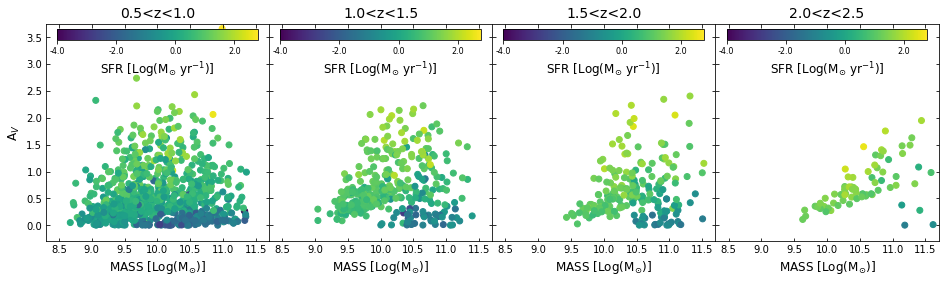

In [18]:
fig = plt.figure(figsize = (16,4))
for i in range (len(tab)):
    
    dvm = plt.subplot(1,4,i+1)
    dvm.set_title(title[i], fontsize = 14)
    polvere = plt.scatter(df[i]['LMASS'], df[i]['AV'], 
                c=df[i]['LSFR'], cmap ='viridis', 
                norm=colors.Normalize(vmin = -4, vmax = np.max(df[0]['LSFR'])), alpha = 1)
    axin = inset_axes(dvm, width = "90%", height = "5%", loc = 'upper center')
    c_bar = fig.colorbar(polvere, cax=axin, orientation = 'horizontal')
    
    if i != 0:
        dvm.set_yticklabels([])
    else:
        dvm.set_ylabel('A$_{V}$', fontsize = 12)
    
    targhette = c_bar.get_ticks()
    for i in range(len(targhette)):
        targhette[i] = round(targhette[i],1)
    
     
    
    axin.xaxis.set_ticks_position("bottom")
    axin.xaxis.set_label_text('SFR [Log(M$_{\odot}$ yr$^{-1}$)]', fontsize = 12)
    axin.xaxis.set_label_position('bottom')
    axin.xaxis.set_ticklabels(ticklabels = targhette , fontsize = 8)
    
    
    dvm.set_ylim(-0.3,3.75)
    dvm.set_xlim(8.3,11.7)
    #DUST vs MASS!!

    dvm.set_xlabel('MASS [Log(M$_{\odot}$)]', fontsize = 12)
    #ricorda che mi rappresenta una "correzione" da applicare alle luminosità ma sono
                            #sempre esponenti
    
    dvm.tick_params(axis='x',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    dvm.tick_params(axis='y',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    dvm.xaxis.set_ticks_position('both')
    dvm.yaxis.set_ticks_position('both')
    

plt.subplots_adjust(wspace = 0)
#plt.savefig('avVSmass_col_sfr.png')
plt.show()
plt.close()


### LSFR vs LMASS (colorato con pop dens)

#### Pallini

#### Isolette

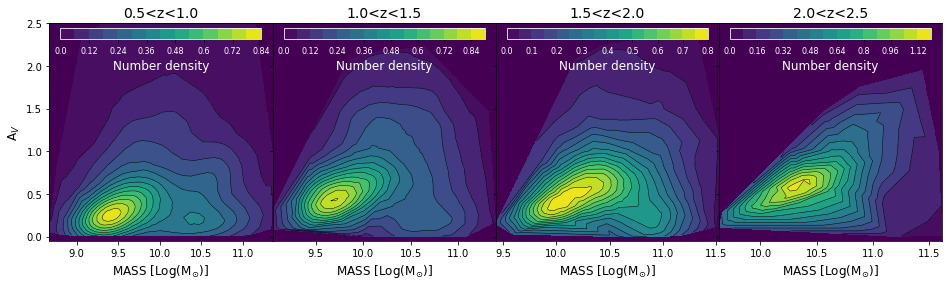

In [19]:
fig = plt.figure(figsize = (16,4))
for i in range (len(tab)):
    
    a = df[i]['LMASS']
    b = df[i]['AV']
    xy = np.vstack([df[i]['LMASS'],df[i]['AV']])
    z = gaussian_kde(xy)(xy)
    
    ngridx = 500
    ngridy = 500
    xi = np.linspace(min(a), max(a), ngridx)
    yi = np.linspace(min(b), max(b), ngridy)

    # Perform linear interpolation of the data (x,y)
    # on a grid defined by (xi,yi)
    triang = tri.Triangulation(a, b)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    ax = plt.subplot(1,4,i+1)
    if i != 0: 
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('A$_{V}$', fontsize = 12) 
    plt.title(title[i], fontsize = 14)
    plt.gca().patch.set_color('#440154FF')
    plt.contour(xi, yi, zi, levels=15, linewidths=0.5, colors='black', corner_mask = True)
    cntr1 = plt.contourf(xi, yi, zi, levels=15, cmap="viridis")
    
    axin = inset_axes(ax, width = "90%", height = "5%", loc = 'upper center')
    c_bar = fig.colorbar(cntr1, cax=axin, orientation = 'horizontal', drawedges = True)
    c_bar.outline.set_edgecolor('w')
    c_bar.dividers.set_linewidth(0.00000000000001)
    targhette = c_bar.get_ticks()
    for i in range(len(targhette)):
        targhette[i] = round(targhette[i],2)
    #print(targhette)
    axin.xaxis.set_label_text('Number density', fontsize = 12, c = 'white')
    axin.xaxis.set_label_position('bottom')
    axin.xaxis.set_ticks_position('bottom')
    axin.xaxis.set_ticklabels(ticklabels = targhette , fontsize = 8, color = 'w')
    
    ax.set_xlabel('MASS [Log(M$_{\odot}$)]', fontsize = 12)
    
    ax.set_ylim(-0.05,2.5)
       
plt.subplots_adjust(wspace = 0)
#plt.savefig('avVSmass_number_density.png')
plt.show()
plt.close()
    
    
  

### SFR vs ETÀ (colorando con TAU e MASSA)

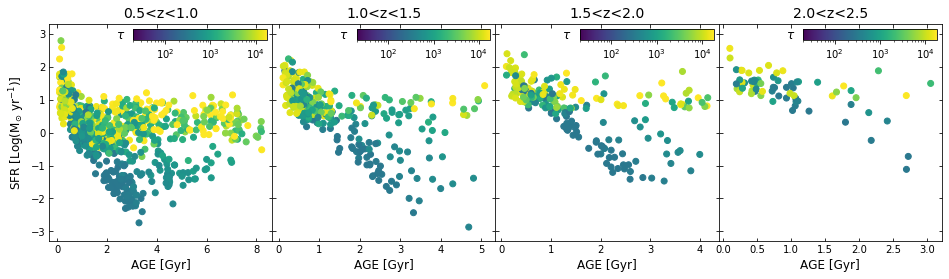

In [20]:
fig = plt.figure(figsize = (16,4))

for i in range (len(tab)):

    ax = plt.subplot(1,4,i+1)
    if i != 0: 
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('SFR [Log(M$_{\odot}$ yr$^{-1})]$', fontsize = 12)
    ax.set_title(title[i], fontsize = 14)
    
   
    albero = plt.scatter(10**(-3)*df[i]['AGE'], df[i]['LSFR'], 
                c = df[i]['TAU'], cmap = 'viridis', norm = colors.LogNorm(vmin = 20, vmax = 18000)) #SFR vs AGE!!
    axin = inset_axes(ax, width = "60%", height = "5%", loc = 'upper right')
    c_bar = fig.colorbar(albero, cax=axin, orientation = 'horizontal', drawedges = True)
    c_bar.outline.set_edgecolor('k')
    c_bar.dividers.set_linewidth(0.0000000000000000000000001)
    plt.text(0.3,0.93,r'$\tau$', transform=ax.transAxes, fontsize = 12)
    axin.xaxis.set_ticks_position('bottom')
    
    ax.set_xlabel('AGE [Gyr]', fontsize = 12)
    ax.set_ylim(-3.3,3.3)    
    ax.tick_params(axis='x',direction = 'in')
    ax.tick_params(axis='y',direction = 'in')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    
    
plt.subplots_adjust(wspace = 0) 
#plt.savefig('sfrVSage_col_tau.png')
plt.show()
plt.close()
    

stessa roba ma con la sSFR

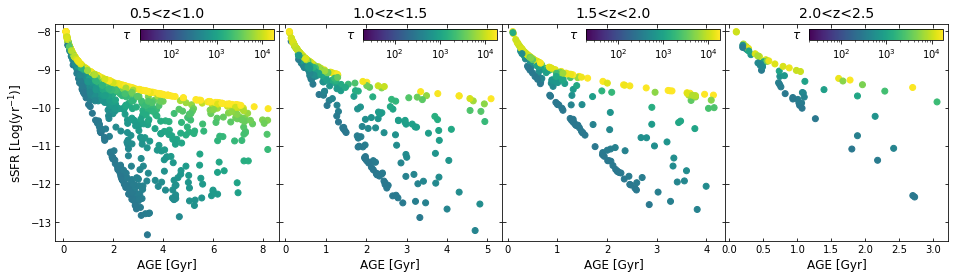

In [21]:
fig = plt.figure(figsize = (16,4))

for i in range (len(tab)):

    ax = plt.subplot(1,4,i+1)
    if i != 0: 
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('sSFR [Log(yr$^{-1})]$', fontsize = 12)
    ax.set_title(title[i], fontsize = 14)
    
   
    albero = plt.scatter(10**(-3)*df[i]['AGE'], df[i]['LSFR']-df[i]['LMASS'], 
                c = df[i]['TAU'], cmap = 'viridis', norm = colors.LogNorm(vmin = 20, vmax = 18000)) #SFR vs AGE!!
    axin = inset_axes(ax, width = "60%", height = "5%", loc = 'upper right')
    c_bar = fig.colorbar(albero, cax=axin, orientation = 'horizontal', drawedges = True)
    c_bar.outline.set_edgecolor('k')
    c_bar.dividers.set_linewidth(0.0000000000000000000000001)
    plt.text(0.3,0.93,r'$\tau$', transform=ax.transAxes, fontsize = 12)
    axin.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('AGE [Gyr]', fontsize = 12)
    
    ax.set_ylim(-13.5,-7.8)
    
    ax.tick_params(axis='x',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax.tick_params(axis='y',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    
    
plt.subplots_adjust(wspace = 0) 
#plt.savefig('ssfrVSage_col_tau.png')
plt.show()
plt.close()

proviamo a colorare con la massa al posto che con la SFR 

non sembra esserci una dipendenza evidente tra i comportamenti delle popolazioni con masse differenti

### SFR vs DUST

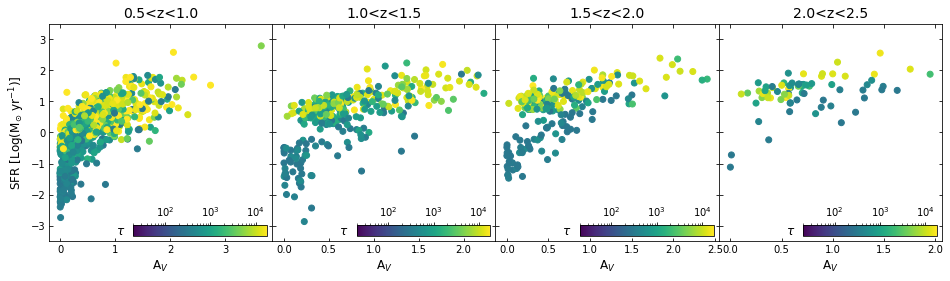

In [22]:
fig = plt.figure(figsize = (16,4))

for i in range (len(tab)):

    ax = plt.subplot(1,4,i+1)
    if i != 0: 
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('SFR [Log(M$_{\odot}$ yr$^{-1})]$', fontsize = 12)
    ax.set_title(title[i], fontsize = 14)
    
   
    albero = plt.scatter(df[i]['AV'], df[i]['LSFR'], 
                c = df[i]['TAU'], cmap = 'viridis', norm = colors.LogNorm(vmin = 20, vmax = 18000)) #SFR vs AGE!!
    axin = inset_axes(ax, width = "60%", height = "5%", loc = 'lower right')
    c_bar = fig.colorbar(albero, cax=axin, orientation = 'horizontal', drawedges = True)
    c_bar.outline.set_edgecolor('k')
    c_bar.dividers.set_linewidth(0.0000000000000000000000001)
    plt.text(0.3,0.03,r'$\tau$', transform=ax.transAxes, fontsize = 12)
    axin.xaxis.set_ticks_position('top')
    ax.set_xlabel('A$_{V}$', fontsize = 12)
    
    ax.set_ylim(-3.5,3.5)
    
    ax.tick_params(axis='x',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax.tick_params(axis='y',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    
    
plt.subplots_adjust(wspace = 0) 
#plt.savefig('sfrVSav_col_tau.png')
plt.show()
plt.close()

### DUST vs AGE 

### grafici suddivisi in intervalli di z

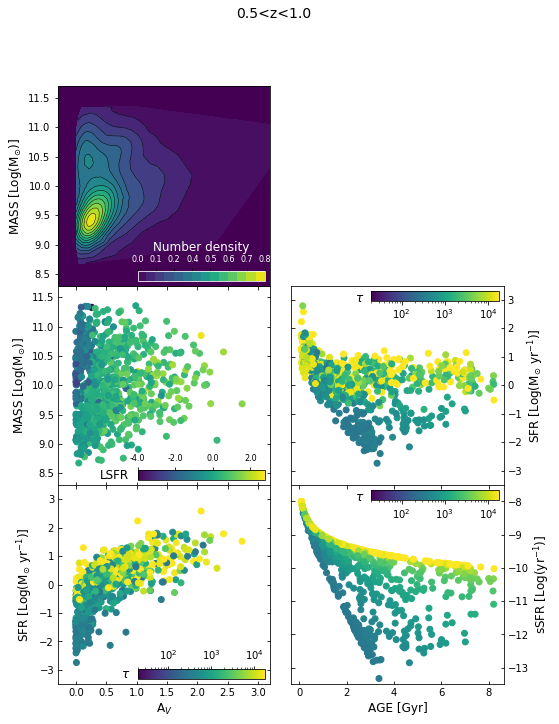

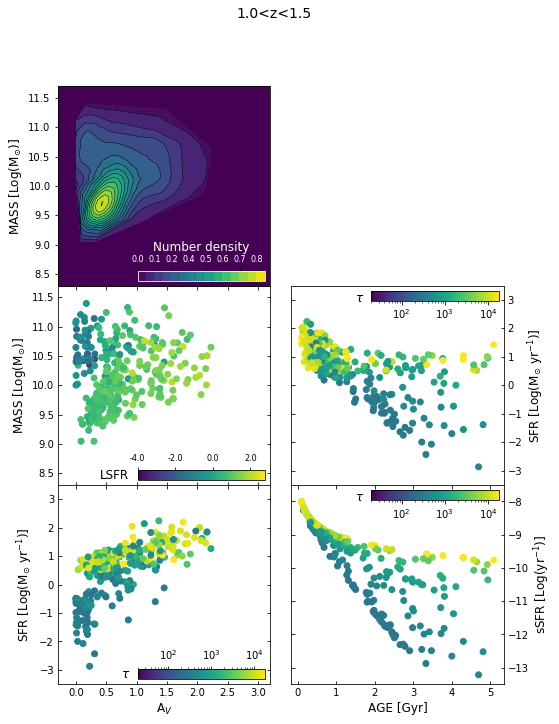

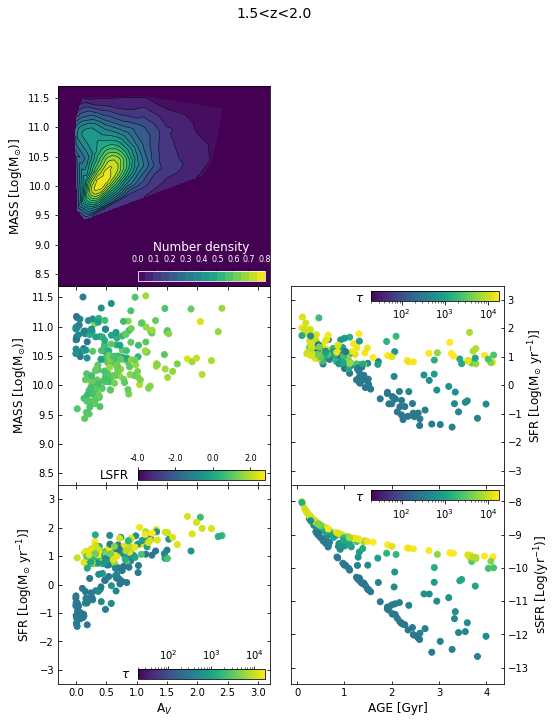

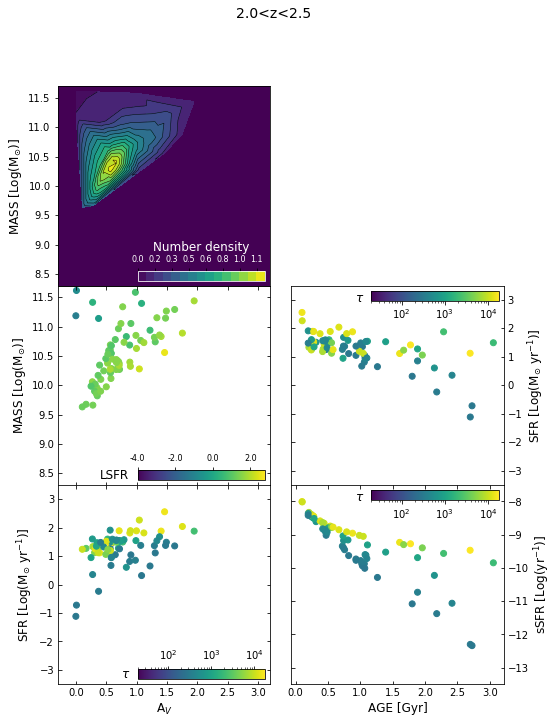

In [23]:


for i in range(4):
    fig = plt.figure(figsize = (8,11))
    plt.suptitle(title[i], fontsize = 14)
    ax0 = plt.subplot(3,2,3)
    polvere = plt.scatter(df[i]['AV'], df[i]['LMASS'], 
                c=df[i]['LSFR'], cmap ='viridis', 
                norm=colors.Normalize(vmin = -4, vmax = np.max(df[0]['LSFR'])), alpha = 1)
    axin = inset_axes(ax0, width = "60%", height = "5%", loc = 'lower right')
    c_bar = fig.colorbar(polvere, cax=axin, orientation = 'horizontal')
    
    ax0.set_ylabel('MASS [Log(M$_{\odot}$)]', fontsize = 12)
    
    targhette = c_bar.get_ticks()
    
    for j in range(len(targhette)):
        targhette[j] = round(targhette[j],1)
    
     
    
    axin.xaxis.set_ticks_position("top")
    plt.text(0.2,0.03,'LSFR', transform=ax0.transAxes, fontsize = 12)
    axin.xaxis.set_ticklabels(ticklabels = targhette , fontsize = 8)
    
    
    ax0.set_ylim(8.3,11.7)
    ax0.set_xlim(-0.3,3.2)
    #DUST vs MASS!!

    #ricorda che mi rappresenta una "correzione" da applicare alle luminosità ma sono
                            #sempre esponenti
    
    ax0.tick_params(axis='x',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax0.tick_params(axis='y',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax0.xaxis.set_ticks_position('both')
    ax0.yaxis.set_ticks_position('both')
    
    
    
    ax1 = plt.subplot(3,2,4)
    albero = plt.scatter(10**(-3)*df[i]['AGE'], df[i]['LSFR'], 
                c = df[i]['TAU'], cmap = 'viridis', norm = colors.LogNorm(vmin = 20, vmax = 18000)) #SFR vs AGE!!
    axin = inset_axes(ax1, width = "60%", height = "5%", loc = 'upper right')
    c_bar = fig.colorbar(albero, cax=axin, orientation = 'horizontal', drawedges = True)
    c_bar.outline.set_edgecolor('k')
    c_bar.dividers.set_linewidth(0.0000000000000000000000001)
    plt.text(0.3,0.92,r'$\tau$', transform=ax1.transAxes, fontsize = 12)
    
    axin.xaxis.set_ticks_position('bottom')

    ax1.set_ylabel('SFR [Log(M$_{\odot}$ yr$^{-1})]$', fontsize = 12)
    ax1.set_xlabel('AGE [Gyr]', fontsize = 12)
    ax1.set_ylim(-3.5,3.5)    
    ax1.tick_params(axis='x',direction = 'in')
    ax1.tick_params(axis='y',direction = 'in')#, labelleft = 'off', labelright = 'on')
    ax1.yaxis.set_label_position('right')
    ax1.yaxis.tick_right()
    ax1.xaxis.set_ticks_position('both')
    ax1.yaxis.set_ticks_position('both')
    ax1.set_xticks([])
    
    
    
    ax2 = plt.subplot(3,2,6)
    pioppo = plt.scatter(10**(-3)*df[i]['AGE'], df[i]['LSFR']-df[i]['LMASS'], 
                c = df[i]['TAU'], cmap = 'viridis', norm = colors.LogNorm(vmin = 20, vmax = 18000)) #SFR vs AGE!!
    axin = inset_axes(ax2, width = "60%", height = "5%", loc = 'upper right')
    c_bar = fig.colorbar(pioppo, cax=axin, orientation = 'horizontal', drawedges = True)
    c_bar.outline.set_edgecolor('k')
    c_bar.dividers.set_linewidth(0.0000000000000000000000001)
    plt.text(0.3,0.92,r'$\tau$', transform=ax2.transAxes, fontsize = 12)
    axin.xaxis.set_ticks_position('bottom')
    ax2.set_ylabel('sSFR [Log(yr$^{-1})]$', fontsize = 12)
    ax2.set_xlabel('AGE [Gyr]', fontsize = 12)
    ax2.set_ylim(-13.5,-7.5)
    ax2.tick_params(axis='x',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax2.tick_params(axis='y',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax2.yaxis.set_label_position('right')
    ax2.yaxis.tick_right()
    ax2.xaxis.set_ticks_position('both')
    ax2.yaxis.set_ticks_position('both')
    
    
    ax3 = plt.subplot(3,2,5)
    salice = plt.scatter(df[i]['AV'], df[i]['LSFR'], 
                c = df[i]['TAU'], cmap = 'viridis', norm = colors.LogNorm(vmin = 20, vmax = 18000)) #SFR vs AGE!!
    axin = inset_axes(ax3, width = "60%", height = "5%", loc = 'lower right')
    c_bar = fig.colorbar(salice, cax=axin, orientation = 'horizontal', drawedges = True)
    c_bar.outline.set_edgecolor('k')
    c_bar.dividers.set_linewidth(0.0000000000000000000000001)
    plt.text(0.3,0.03,r'$\tau$', transform=ax3.transAxes, fontsize = 12)
    axin.xaxis.set_ticks_position('top')
    ax3.set_ylabel('SFR [Log(M$_{\odot}$ yr$^{-1})]$', fontsize = 12)
    ax3.set_xlabel('A$_{V}$', fontsize = 12)
    ax3.set_ylim(-3.5,3.5)
    ax3.set_xlim(-0.3,3.2)
    ax3.tick_params(axis='x',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax3.tick_params(axis='y',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax3.xaxis.set_ticks_position('both')
    ax3.yaxis.set_ticks_position('both')

    
    ax4 = plt.subplot(3,2,1)
    a = df[i]['AV']
    b = df[i]['LMASS']
    xy = np.vstack([df[i]['AV'],df[i]['LMASS']])
    z = gaussian_kde(xy)(xy)
    
    ngridx = 500
    ngridy = 500
    xi = np.linspace(min(a), max(a), ngridx)
    yi = np.linspace(min(b), max(b), ngridy)

    # Perform linear interpolation of the data (x,y)
    # on a grid defined by (xi,yi)
    triang = tri.Triangulation(a, b)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

  
    
    #ax4.set_ylabel('A$_{V}$', fontsize = 12) 
    plt.gca().patch.set_color('#440154FF')
    plt.contour(xi, yi, zi, levels=15, linewidths=0.5, colors='black', corner_mask = True)
    cntr1 = plt.contourf(xi, yi, zi, levels=15, cmap="viridis")
    
    axin = inset_axes(ax4, width = "60%", height = "5%", loc = 'lower right')
    c_bar = fig.colorbar(cntr1, cax=axin, orientation = 'horizontal', drawedges = True)
    c_bar.outline.set_edgecolor('w')
    c_bar.dividers.set_linewidth(0.00000000000001)
    targhette = c_bar.get_ticks()
    for k in range(len(targhette)):
        targhette[k] = round(targhette[k],1)
    #print(targhette)
    axin.xaxis.set_label_text('Number density', fontsize = 12, c = 'white')
    axin.xaxis.set_label_position('top')
    axin.xaxis.set_ticks_position('top')
    axin.xaxis.set_ticklabels(ticklabels = targhette , fontsize = 8, color = 'w')
    #ax4.set_xlabel('MASS [Log(M$_{\odot}$)]', fontsize = 12)
    ax4.set_ylim(8.3,11.7)
    ax4.set_xlim(-0.3,3.2)
    ax4.set_xticks([])
    ax4.set_ylabel('MASS [Log(M$_{\odot}$)]', fontsize = 12)
    
    plt.subplots_adjust(wspace = 0.1, hspace = 0)
    plt.show()
    #fig.savefig('params_in_'+str(title[i])+'.png')


# Color-color diagram

Dovremmo selezionare le bande U, V e J (ci sono i txt) e fare un integrale sulla larghezza di banda per ottenere flusso specifico (del RF) a quella banda. Poi sottrarre U-V e V-J e plottare i due come UV vs VJ. Una volta fatto questo ragionameto dovremmo osservare due regioni distinte, separate da una retta diagonare di cui prendiamo i parametri dal paper di Whitaker (2011 forse). Poi basta colorare il grafico per la sfr. PER OGNI SORGENTE

Leggo i filtri

In [24]:
U = ascii.read('file:///data1/astlab04/cc_data/Johnson_U.dat')
V = ascii.read('file:///data1/astlab04/cc_data/Johnson_V.dat')
J = ascii.read('file:///data1/astlab04/cc_data/2MASS_J.dat')

Leggo i fits e li divido direttamente negli intervalli di z fissati sopra.

Gli elementi in tab[i] sono già selezionati per gli intervalli di z che mi interessano, leggo l'identificativo della sorgente che mi interessa e lo salvo in una lista.

In [25]:
sorgenti_1 = []        #sono liste di tabelle        
sorgenti_2 = []        #queste liste avranno i dati sed delle galassia nel primo, secondo, 
sorgenti_3 = []        #terzo e quarto intervallo di redshift
sorgenti_4 = []



for k in (tab[0]['sorgente']): 
    sorgenti_1.append(QTable(fits.getdata('file:///data1/astrolab/data/projects/3dhst/SPS/Plots/id'
                             + str(k) +'_best_sed.fits',1))) # Z = (0.5,1.)

for k in (tab[1]['sorgente']):
    sorgenti_2.append(QTable(fits.getdata('file:///data1/astrolab/data/projects/3dhst/SPS/Plots/id'
                             + str(k) +'_best_sed.fits',1))) # Z = (1.,1.5)
    
for k in (tab[2]['sorgente']):
    sorgenti_3.append(QTable(fits.getdata('file:///data1/astrolab/data/projects/3dhst/SPS/Plots/id'
                             + str(k) +'_best_sed.fits',1))) # Z = (1.5,2.)

for k in (tab[3]['sorgente']):
    sorgenti_4.append(QTable(fits.getdata('file:///data1/astrolab/data/projects/3dhst/SPS/Plots/id'
                             + str(k) +'_best_sed.fits',1))) # Z = (2.,2.5) 

#per comodità salvo tutto in un'unica lista
sorgenti = [sorgenti_1, sorgenti_2, sorgenti_3, sorgenti_4] 

ogni lista è lunga come gli elementi contenuti nel fissato intervallo di z, per ogni sorgente ho una tabella contenente le lunghezze d'onda sia nel rf che osservate (ogni tabella è lunga 6970 righe che rappresentano le lunghezze di sensibilità dello strumento)

U, V e J sono le bande di sensibilità che mi interessano, sulle ordinate ho l'indice di trasmissione del ricevitore in quell'intervallo di $\lambda$

In [26]:
sorgenti[0][0]

wave_obs,wave_rest,f_lam_obs,f_lam_rest,f_nu_obs
float32,float32,float32,float32,float32
139.5576,91.0,0.0,0.0,0.0
144.1584,94.0,0.0,0.0,0.0
147.2256,96.0,0.0,0.0,0.0
150.2928,98.0,0.0,0.0,0.0
153.36,100.0,0.0,0.0,0.0
156.4272,102.0,0.0,0.0,0.0
159.4944,104.0,0.0,0.0,0.0
162.5616,106.0,0.0,0.0,0.0
165.6288,108.0,0.0,0.0,0.0


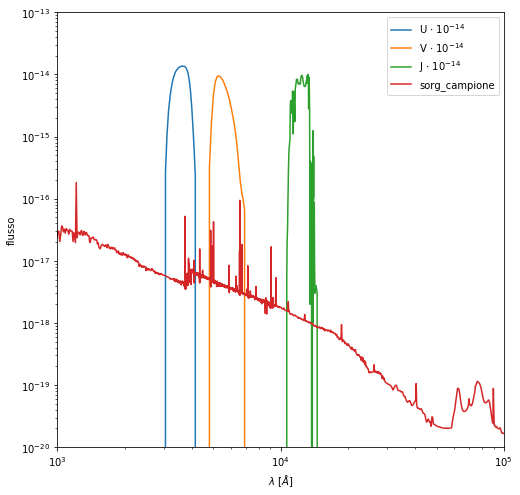

In [27]:
fig = plt.figure( figsize=(8,8))

plt.plot(U['Wave'], U['Trans']*10**(-14), label = 'U $\cdot$ 10$^{-14}$')   #abbasso a mano la T_lambda per vederla riferita ai dati 
                                                         #di una sorgente
plt.plot(V['Wave'], V['Trans']*10**(-14), label = 'V $\cdot$ 10$^{-14}$')
plt.plot(J['Wave'], J['Trans']*10**(-14), label = 'J $\cdot$ 10$^{-14}$')
plt.plot(sorgenti_1[0]['wave_rest'], sorgenti_1[0]['f_lam_rest'], label = 'sorg_campione')
plt.xscale('Log')
plt.yscale('Log')
plt.xlim(10**3, 10**5)
plt.ylim(10**(-20), 10**(-13))
plt.legend()
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.ylabel('flusso')
#plt.savefig('banda_sensibilità_UVJ.png')
plt.show()

selezioniamo le y corrispondenti alle bande di trasmissione in modo da poter fare l'integrale tra gli elemti che ho nella banda di sensibilità (U ha 25 intervalli di frequenza specifica, mi interessa trovare i corrispondenti y del flusso). Faccio questa operazione interpolado le lunghezze d'onda di sensibilità dello strumento con quelle della sorgente.

In [28]:

#filtro U
U_interp_1 = []
for i in range(len(sorgenti_1)):
       U_interp_1.append(np.interp(U['Wave'], sorgenti_1[i]['wave_rest'], sorgenti_1[i]['f_lam_rest']))
        
U_interp_2 = []
for i in range(len(sorgenti_2)):
       U_interp_2.append(np.interp(U['Wave'], sorgenti_2[i]['wave_rest'], sorgenti_2[i]['f_lam_rest']))
        
U_interp_3 = []
for i in range(len(sorgenti_3)):
       U_interp_3.append(np.interp(U['Wave'], sorgenti_3[i]['wave_rest'], sorgenti_3[i]['f_lam_rest']))
        
U_interp_4 = []
for i in range(len(sorgenti_4)):
       U_interp_4.append(np.interp(U['Wave'], sorgenti_4[i]['wave_rest'], sorgenti_4[i]['f_lam_rest']))
        
        

#filtro V
V_interp_1 = []
for i in range(len(sorgenti_1)):
       V_interp_1.append(np.interp(V['Wave'], sorgenti_1[i]['wave_rest'], sorgenti_1[i]['f_lam_rest']))
        
V_interp_2 = []
for i in range(len(sorgenti_2)):
       V_interp_2.append(np.interp(V['Wave'], sorgenti_2[i]['wave_rest'], sorgenti_2[i]['f_lam_rest']))
        
V_interp_3 = []
for i in range(len(sorgenti_3)):
       V_interp_3.append(np.interp(V['Wave'], sorgenti_3[i]['wave_rest'], sorgenti_3[i]['f_lam_rest']))
        
V_interp_4 = []
for i in range(len(sorgenti_4)):
       V_interp_4.append(np.interp(V['Wave'], sorgenti_4[i]['wave_rest'], sorgenti_4[i]['f_lam_rest']))
        
      
    
#filtro J
J_interp_1 = []
for i in range(len(sorgenti_1)):
       J_interp_1.append(np.interp(J['Wave'], sorgenti_1[i]['wave_rest'], sorgenti_1[i]['f_lam_rest']))
        
J_interp_2 = []
for i in range(len(sorgenti_2)):
       J_interp_2.append(np.interp(J['Wave'], sorgenti_2[i]['wave_rest'], sorgenti_2[i]['f_lam_rest']))
        
J_interp_3 = []
for i in range(len(sorgenti_3)):
       J_interp_3.append(np.interp(J['Wave'], sorgenti_3[i]['wave_rest'], sorgenti_3[i]['f_lam_rest']))
        
J_interp_4 = []
for i in range(len(sorgenti_4)):
       J_interp_4.append(np.interp(J['Wave'], sorgenti_4[i]['wave_rest'], sorgenti_4[i]['f_lam_rest']))


U_interp = [U_interp_1, U_interp_2, U_interp_3, U_interp_4]        
V_interp = [V_interp_1, V_interp_2, V_interp_3, V_interp_4]
J_interp = [J_interp_1, J_interp_2, J_interp_3, J_interp_4]


faccio l'integrale sulle varie bande.

In [29]:

mag_U = []
mag_V = []
mag_J = []

#ciclo su U
for k in range(len(sorgenti)):
    num_integral = []
    den_integral = []
    for i in range (len(sorgenti[k])):
        sum_num = 0
        sum_den = 0

        for j in range(len(U)):
            sum_num+=U['Wave'][j]*U['Trans'][j]*U_interp[k][i][j]
            sum_den+=U['Trans'][j]/U['Wave'][j]*(c.value*(10**(10)))

        num_integral.append(sum_num)
        den_integral.append(sum_den)        

    flux_U = np.array(num_integral)/np.array(den_integral)
    mag_U.append(-2.5*np.log10(flux_U))
        
mag_U = np.array(mag_U)
        
#ciclo su V
for k in range(len(sorgenti)):
    num_integral = []
    den_integral = []
    for i in range (len(sorgenti[k])):
        sum_num = 0
        sum_den = 0

        for j in range(len(V)):
            sum_num+=V['Wave'][j]*V['Trans'][j]*V_interp[k][i][j]
            sum_den+=V['Trans'][j]/V['Wave'][j]*(c.value*(10**(10)))

        num_integral.append(sum_num)
        den_integral.append(sum_den)        

    flux_V = np.array(num_integral)/np.array(den_integral)
    mag_V.append(-2.5*np.log10(flux_V))
    
mag_V = np.array(mag_V)
    
#ciclo su J
for k in range(len(sorgenti)):
    num_integral = []
    den_integral = []
    for i in range (len(sorgenti[k])):
        sum_num = 0
        sum_den = 0

        for j in range(len(J)):
            sum_num+=J['Wave'][j]*J['Trans'][j]*J_interp[k][i][j]
            sum_den+=J['Trans'][j]/J['Wave'][j]*(c.value*(10**(10)))

        num_integral.append(sum_num)
        den_integral.append(sum_den)        

    flux_J = np.array(num_integral)/np.array(den_integral)
    mag_J.append(-2.5*np.log10(flux_J))
    
mag_J = np.array(mag_J)

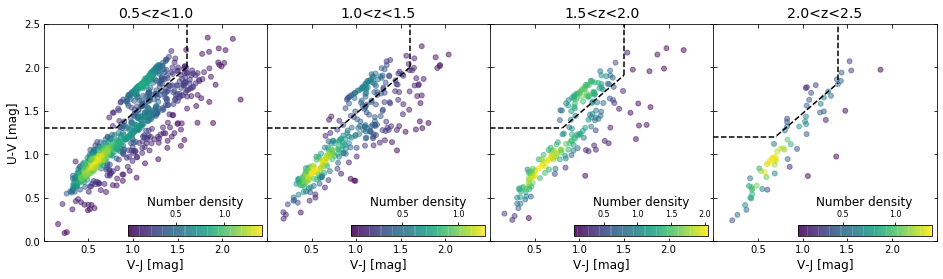

In [30]:

fig = plt.figure( figsize=(16,4))
for i in range(len(sorgenti)):
    xy = np.vstack([mag_V[i]-mag_J[i],mag_U[i]-mag_V[i]])
    z=gaussian_kde(xy)(xy)
    ax4 = plt.subplot(1,4,i+1)
    ax4.tick_params(axis='x',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax4.tick_params(axis='y',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax4.xaxis.set_ticks_position('both')
    ax4.yaxis.set_ticks_position('both')
    quercia = plt.scatter(mag_V[i]-mag_J[i], mag_U[i]-mag_V[i], marker = '.', s = 100, alpha=0.5, c=z,
                    cmap = 'viridis')
    
    axin = inset_axes(ax4, width = "60%", height = "5%", loc = 'lower right')
    c_bar = fig.colorbar(quercia, cax=axin, orientation = 'horizontal', drawedges = True)
    #c_bar.outline.set_edgecolor('w')
    c_bar.dividers.set_linewidth(0.00000000000001)
    targhette = c_bar.get_ticks()
    for k in range(len(targhette)):
        targhette[k] = round(targhette[k],1)
    #print(targhette)
    axin.xaxis.set_label_text('Number density', fontsize = 12)#, c = 'white')
    axin.xaxis.set_label_position('top')
    axin.xaxis.set_ticks_position('top')
    axin.xaxis.set_ticklabels(ticklabels = targhette , fontsize = 8)#, color = 'w')
    
    if i == 0:
        ax4.axhline(y= 1.3,xmin = 0, xmax = 0.27*3/2.5, ls='--', c = 'black')
        ax4.axvline(1.6,ymin = 0.8,ymax = 1,ls='--', c = 'k')
        x = np.linspace(0.81,1.6,1000000)
        ax4.plot(x, 0.88*x+0.59, '--', c = 'black')
        ax4.set_ylabel('U-V [mag]', fontsize = 12)

    
    elif i == 1:
        ax4.axhline(y= 1.3,xmin = 0, xmax = 0.27*3/2.5, ls='--', c = 'black')
        ax4.axvline(1.6,ymin = 0.8,ymax = 1,ls='--', c = 'k')
        x = np.linspace(0.81,1.6,1000000)
        ax4.plot(x, 0.88*x+0.59, '--', c = 'black')
        ax4.set_yticklabels([])
                
    elif i == 2:
        ax4.axhline(y = 1.3, xmin =0, xmax = 0.27*3/2.5,ls='--', c = 'k')
        ax4.axvline(1.5,ymin = 0.764,ymax = 1,ls='--', c = 'k')
        x = np.linspace(0.81,1.5,1000000)
        ax4.plot(x, 0.88*x+0.59, '--', c = 'black')
        ax4.set_yticklabels([])
        
    elif i == 3:
        ax4.axhline(y=1.2, xmin = 0,xmax = 0.237*3/2.5, ls='--', c = 'k')
        ax4.axvline(x = 1.4,ymin = 0.74, ymax=1,ls='--', c = 'k')
        x = np.linspace(0.71,1.4,1000000)
        ax4.plot(x, 0.88*x+0.59, '--', c = 'black')
        ax4.set_yticklabels([])
    
    ax4.set_xticklabels(['','0.5','1.0','1.5','2.0',''])    
    
    ax4.set_title(title[i], fontsize = 14) 
    ax4.set_xlabel('V-J [mag]', fontsize = 12)
    ax4.set_xlim(0,2.5)
    ax4.set_ylim(0,2.5)
    
    plt.subplots_adjust(wspace = 0)
    
    
#plt.savefig('UVJ_density.png')    
plt.show()

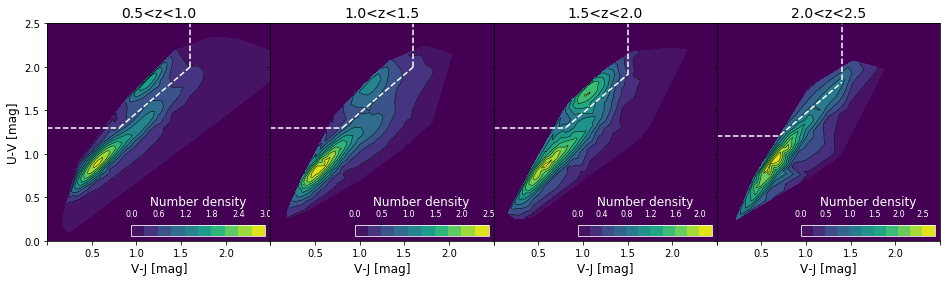

In [31]:
fig = plt.figure(figsize = (16,4))
for i in range (len(tab)):
    
    a = mag_V[i]-mag_J[i]
    b = mag_U[i]-mag_V[i]
    xy = np.vstack([mag_V[i]-mag_J[i],mag_U[i]-mag_V[i]])
    z = gaussian_kde(xy)(xy)
    
    ngridx = 500
    ngridy = 500
    xi = np.linspace(min(a), max(a), ngridx)
    yi = np.linspace(min(b), max(b), ngridy)

    # Perform linear interpolation of the data (x,y)
    # on a grid defined by (xi,yi)
    triang = tri.Triangulation(a, b)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    ax = plt.subplot(1,4,i+1)
    if i != 0: 
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('V-J [mag]', fontsize = 12) 
    plt.title(title[i], fontsize = 14)
    plt.gca().patch.set_color('#440154FF')
    plt.contour(xi, yi, zi, levels=10, linewidths=0.5, colors='black', corner_mask = True)
    cntr1 = plt.contourf(xi, yi, zi, levels=10, cmap="viridis")
    
    if i == 0:
        ax.axhline(y= 1.3,xmin = 0, xmax = 0.27*3/2.5, ls='--', c = 'w')
        ax.axvline(1.6,ymin = 0.8,ymax = 1,ls='--', c = 'w')
        x = np.linspace(0.81,1.6,1000000)
        ax.plot(x, 0.88*x+0.59, '--', c = 'w')
        ax.set_ylabel('U-V [mag]', fontsize = 12)

    
    elif i == 1:
        ax.axhline(y= 1.3,xmin = 0, xmax = 0.27*3/2.5, ls='--', c = 'w')
        ax.axvline(1.6,ymin = 0.8,ymax = 1,ls='--', c = 'w')
        x = np.linspace(0.81,1.6,1000000)
        ax.plot(x, 0.88*x+0.59, '--', c = 'w')
        ax.set_yticklabels([])
                
    elif i == 2:
        ax.axhline(y = 1.3, xmin =0, xmax = 0.27*3/2.5,ls='--', c = 'w')
        ax.axvline(1.5,ymin = 0.764,ymax = 1,ls='--', c = 'w')
        x = np.linspace(0.81,1.5,1000000)
        ax.plot(x, 0.88*x+0.59, '--', c = 'white')
        ax.set_yticklabels([])
        
    elif i == 3:
        ax.axhline(y=1.2, xmin = 0,xmax = 0.237*3/2.5, ls='--', c = 'w')
        ax.axvline(x = 1.4,ymin = 0.74, ymax=1,ls='--', c = 'w')
        x = np.linspace(0.71,1.4,1000000)
        ax.plot(x, 0.88*x+0.59, '--', c = 'w')
        ax.set_yticklabels([])
    
    axin = inset_axes(ax, width = "60%", height = "5%", loc = 'lower right')
    c_bar = fig.colorbar(cntr1, cax=axin, orientation = 'horizontal', drawedges = True)
    c_bar.outline.set_edgecolor('w')
    c_bar.dividers.set_linewidth(0.00000000000001)
    targhette = c_bar.get_ticks()
    for i in range(len(targhette)):
        targhette[i] = round(targhette[i],2)
    
    targhette_0 = np.zeros(5)
    if i == 0:
        for u in range(4):
            targhette_0[u] = targhette[u]
    #print(targhette)
    axin.xaxis.set_label_text('Number density', fontsize = 12, c = 'white')    
    axin.xaxis.set_ticklabels(ticklabels = targhette , fontsize = 8, color = 'w')        
    axin.xaxis.set_label_position('top')
    axin.xaxis.set_ticks_position('top')
    
    ax.set_xlabel('U-J [mag]', fontsize = 12)
    
   
    

        
    ax.set_xticklabels(['','0.5','1.0','1.5','2.0',''])    
    #ax.set_title(title[i], fontsize = 14) 
    ax.set_xlabel('V-J [mag]', fontsize = 12)
    ax.set_xlim(0,2.5)
    ax.set_ylim(0,2.5)

plt.subplots_adjust(wspace = 0)
#plt.savefig('UVJ_density_islands.png')
plt.show()
plt.close()
    
    
  

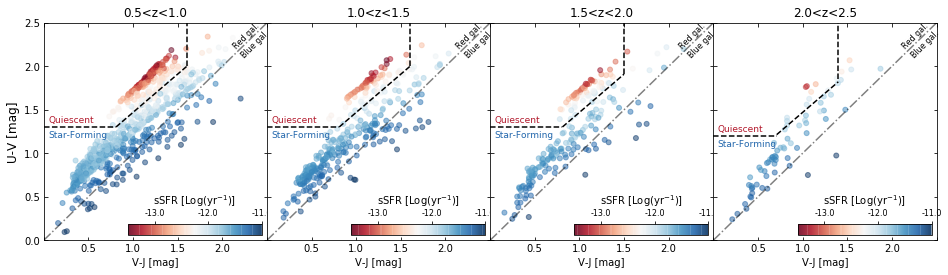

In [32]:
fig = plt.figure( figsize=(16,4))
for i in range(len(sorgenti)):
    ax = plt.subplot(1,4,i+1)
    quercia = plt.scatter(mag_V[i]-mag_J[i], mag_U[i]-mag_V[i], marker = '.', s = 100, alpha=0.5,
                    c = df[i]['LSFR']-df[i]['LMASS'], 
                    cmap = 'RdBu', norm = colors.Normalize(vmin = -13, vmax = -8) )
    
    ax.tick_params(axis='x',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax.tick_params(axis='y',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    x1 = np.linspace(0,2.5,1000)
    ax.plot(x1,x1, '-.', c = 'k', alpha = 0.5)
    plt.annotate(xy = (2.1,2.2), s = 'Red gal.', rotation = 45, fontsize = 8)
    plt.annotate(xy = (2.2,2.1), s = 'Blue gal.', rotation = 45, fontsize = 8)

    if i == 0:
        ax.axhline(y= 1.3,xmin = 0, xmax = 0.27*3/2.5, ls='--', c = 'k')
        ax.axvline(1.6,ymin = 0.8,ymax = 1,ls='--', c = 'k')
        x = np.linspace(0.81,1.6,1000000)
        ax.plot(x, 0.88*x+0.59, '--', c = 'k')
        ax.set_ylabel('U-V [mag]', fontsize = 12)
        plt.annotate(xy = (0.05,1.35), s ='Quiescent', c = '#b2182b', fontsize = 9)
        plt.annotate(xy = (0.05,1.18), s ='Star-Forming', c = '#2166ac', fontsize = 9)
    
    elif i == 1:
        ax.axhline(y= 1.3,xmin = 0, xmax = 0.27*3/2.5, ls='--', c = 'k')
        ax.axvline(1.6,ymin = 0.8,ymax = 1,ls='--', c = 'k')
        x = np.linspace(0.81,1.6,1000000)
        ax.plot(x, 0.88*x+0.59, '--', c = 'k')
        plt.annotate(xy = (0.05,1.35), s ='Quiescent', c = '#b2182b', fontsize = 9)
        plt.annotate(xy = (0.05,1.18), s ='Star-Forming', c = '#2166ac', fontsize = 9)
        ax.set_yticklabels([])
                
    elif i == 2:
        ax.axhline(y = 1.3, xmin =0, xmax = 0.27*3/2.5,ls='--', c = 'k')
        ax.axvline(1.5,ymin = 0.764,ymax = 1,ls='--', c = 'k')
        x = np.linspace(0.81,1.5,1000000)
        ax.plot(x, 0.88*x+0.59, '--', c = 'k')
        plt.annotate(xy = (0.05,1.35), s ='Quiescent', c = '#b2182b', fontsize = 9)
        plt.annotate(xy = (0.05,1.18), s ='Star-Forming', c = '#2166ac', fontsize = 9)
        ax.set_yticklabels([])
        
    elif i == 3:
        ax.axhline(y=1.2, xmin = 0,xmax = 0.237*3/2.5, ls='--', c = 'k')
        ax.axvline(x = 1.4,ymin = 0.74, ymax=1,ls='--', c = 'k')
        x = np.linspace(0.71,1.4,1000000)
        ax.plot(x, 0.88*x+0.59, '--', c = 'k')
        plt.annotate(xy = (0.05,1.25), s ='Quiescent', c = '#b2182b', fontsize = 9)
        plt.annotate(xy = (0.05,1.08), s ='Star-Forming', c = '#2166ac', fontsize = 9)
        ax.set_yticklabels([])
    
    axin = inset_axes(ax, width = "60%", height = "5%", loc = 'lower right')
    c_bar = fig.colorbar(quercia, cax=axin, orientation = 'horizontal', drawedges = True)
    #c_bar.outline.set_edgecolor('w')
    c_bar.dividers.set_linewidth(0.00000000000001)
    targhette = c_bar.get_ticks()
    for k in range(len(targhette)):
        targhette[k] = int(targhette[k])
    #print(targhette)
    axin.xaxis.set_label_text('sSFR [Log(yr$^{-1}$)]', fontsize = 10)#, c = 'white')
    axin.xaxis.set_label_position('top')
    axin.xaxis.set_ticks_position('top')
    axin.xaxis.set_ticklabels(ticklabels = targhette , fontsize = 8)#, color = 'w')
    ax.set_xticklabels(['','0.5','1.0','1.5','2.0',''])  
    ax.set_xlabel('V-J [mag]')
    ax.set_xlim(0,2.5)
    ax.set_ylim(0,2.5)
    ax.set_title(title[i])
    
    
plt.subplots_adjust(wspace=0)
#fig.savefig('UVJ_sSFR.png')

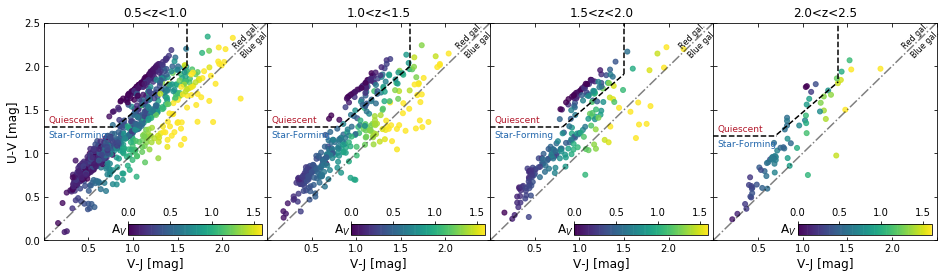

In [33]:
fig = plt.figure( figsize=(16,4))
for i in range(len(sorgenti)):
    ax = plt.subplot(1,4,i+1)
    quercia = plt.scatter(mag_V[i]-mag_J[i], mag_U[i]-mag_V[i], marker = '.', s = 100, alpha=0.8,
                    c = df[i]['AV'], 
                    cmap = 'viridis', norm = colors.Normalize(vmin = 0, vmax = 1.6) )
    
    ax.tick_params(axis='x',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax.tick_params(axis='y',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    x1 = np.linspace(0,2.5,1000)
    ax.plot(x1,x1, '-.', c = 'k', alpha = 0.5)
    plt.annotate(xy = (2.1,2.2), s = 'Red gal.', rotation = 45, fontsize = 8)
    plt.annotate(xy = (2.2,2.1), s = 'Blue gal.', rotation = 45, fontsize = 8)
    if i == 0:
        ax.axhline(y= 1.3,xmin = 0, xmax = 0.27*3/2.5, ls='--', c = 'k')
        ax.axvline(1.6,ymin = 0.8,ymax = 1,ls='--', c = 'k')
        x = np.linspace(0.81,1.6,1000000)
        ax.plot(x, 0.88*x+0.59, '--', c = 'k')
        ax.set_ylabel('U-V [mag]', fontsize = 12)
        plt.annotate(xy = (0.05,1.35), s ='Quiescent', c = '#b2182b', fontsize = 9)
        plt.annotate(xy = (0.05,1.18), s ='Star-Forming', c = '#2166ac', fontsize = 9)
    
    elif i == 1:
        ax.axhline(y= 1.3,xmin = 0, xmax = 0.27*3/2.5, ls='--', c = 'k')
        ax.axvline(1.6,ymin = 0.8,ymax = 1,ls='--', c = 'k')
        x = np.linspace(0.81,1.6,1000000)
        ax.plot(x, 0.88*x+0.59, '--', c = 'k')
        
        plt.annotate(xy = (0.05,1.35), s ='Quiescent', c = '#b2182b', fontsize = 9)
        plt.annotate(xy = (0.05,1.18), s ='Star-Forming', c = '#2166ac', fontsize = 9)
        ax.set_yticklabels([])
                
    elif i == 2:
        ax.axhline(y = 1.3, xmin =0, xmax = 0.27*3/2.5,ls='--', c = 'k')
        ax.axvline(1.5,ymin = 0.764,ymax = 1,ls='--', c = 'k')
        x = np.linspace(0.81,1.5,1000000)
        ax.plot(x, 0.88*x+0.59, '--', c = 'k')
        plt.annotate(xy = (0.05,1.35), s ='Quiescent', c = '#b2182b', fontsize = 9)
        plt.annotate(xy = (0.05,1.18), s ='Star-Forming', c = '#2166ac', fontsize = 9)
        ax.set_yticklabels([])
        
    elif i == 3:
        ax.axhline(y=1.2, xmin = 0,xmax = 0.237*3/2.5, ls='--', c = 'k')
        ax.axvline(x = 1.4,ymin = 0.74, ymax=1,ls='--', c = 'k')
        x = np.linspace(0.71,1.4,1000000)
        ax.plot(x, 0.88*x+0.59, '--', c = 'k')
        plt.annotate(xy = (0.05,1.25), s ='Quiescent', c = '#b2182b', fontsize = 9)
        plt.annotate(xy = (0.05,1.08), s ='Star-Forming', c = '#2166ac', fontsize = 9)
        ax.set_yticklabels([])
    
    axin = inset_axes(ax, width = "60%", height = "5%", loc = 'lower right')
    c_bar = fig.colorbar(quercia, cax=axin, orientation = 'horizontal', drawedges = True)
    #c_bar.outline.set_edgecolor('w')
    c_bar.dividers.set_linewidth(0.00000000000001)
    #print(targhette)
    #axin.xaxis.set_label_text('A$_{V}$', fontsize = 8)#, c = 'white')
    plt.text(0.3,0.03, 'A$_{V}$',transform=ax.transAxes, fontsize = 12)
    axin.xaxis.set_label_position('top')
    axin.xaxis.set_ticks_position('top')
    ax.set_xticklabels(['','0.5','1.0','1.5','2.0',''])  
    ax.set_xlabel('V-J [mag]', fontsize = 12)
    ax.set_xlim(0,2.5)
    ax.set_ylim(0,2.5)
    ax.set_title(title[i])
    
    
plt.subplots_adjust(wspace=0)
#fig.savefig('UVJ_AV.png')

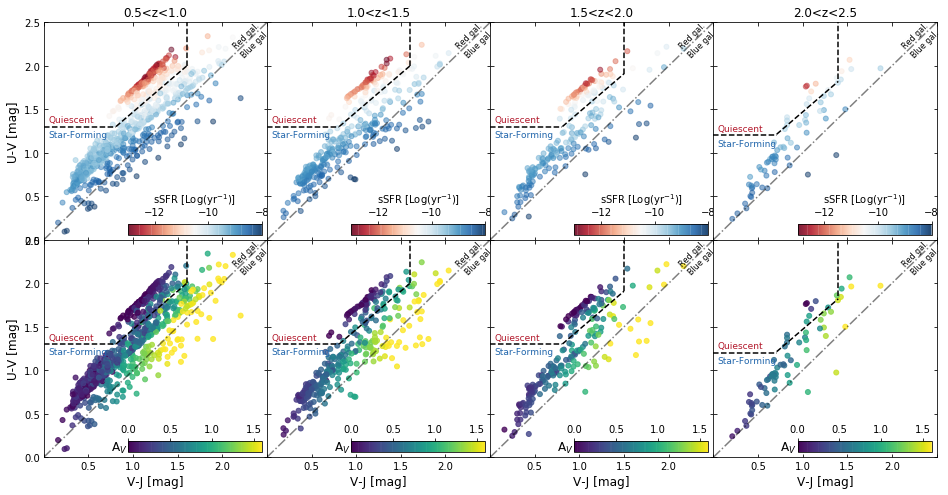

In [34]:
fig = plt.figure( figsize=(16,8))
for i in range(2*len(sorgenti)):
   
    if i < 4:
        ax1 = plt.subplot(2,4,i+1)
        quercia1 = plt.scatter(mag_V[i]-mag_J[i], mag_U[i]-mag_V[i], marker = '.', s = 100, alpha=0.5,
                        c = df[i]['LSFR']-df[i]['LMASS'], 
                        cmap = 'RdBu', norm = colors.Normalize(vmin = -13, vmax = -8) )

        ax1.tick_params(axis='x',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
        ax1.tick_params(axis='y',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
        ax1.xaxis.set_ticks_position('both')
        ax1.yaxis.set_ticks_position('both')
        x1 = np.linspace(0,2.5,1000)
        ax1.plot(x1,x1, '-.', c = 'k', alpha = 0.5)
        plt.annotate(xy = (2.1,2.2), s = 'Red gal.', rotation = 45, fontsize = 8)
        plt.annotate(xy = (2.2,2.1), s = 'Blue gal.', rotation = 45, fontsize = 8)
        
        

        if i == 0:
            ax1.axhline(y= 1.3,xmin = 0, xmax = 0.27*3/2.5, ls='--', c = 'k')
            ax1.axvline(1.6,ymin = 0.8,ymax = 1,ls='--', c = 'k')
            x = np.linspace(0.81,1.6,1000000)
            ax1.plot(x, 0.88*x+0.59, '--', c = 'k')
            plt.annotate(xy = (0.05,1.35), s ='Quiescent', c = '#b2182b', fontsize = 9)
            plt.annotate(xy = (0.05,1.18), s ='Star-Forming', c = '#2166ac', fontsize = 9)
            ax1.set_ylabel('U-V [mag]', fontsize = 12)
            
        elif i == 1:
            ax1.axhline(y= 1.3,xmin = 0, xmax = 0.27*3/2.5, ls='--', c = 'k')
            ax1.axvline(1.6,ymin = 0.8,ymax = 1,ls='--', c = 'k')
            x = np.linspace(0.81,1.6,1000000)
            ax1.plot(x, 0.88*x+0.59, '--', c = 'k')
            plt.annotate(xy = (0.05,1.35), s ='Quiescent', c = '#b2182b', fontsize = 9)
            plt.annotate(xy = (0.05,1.18), s ='Star-Forming', c = '#2166ac', fontsize = 9)
            ax1.set_yticklabels([])

        elif i == 2:
            ax1.axhline(y = 1.3, xmin =0, xmax = 0.27*3/2.5,ls='--', c = 'k')
            ax1.axvline(1.5,ymin = 0.764,ymax = 1,ls='--', c = 'k')
            x = np.linspace(0.81,1.5,1000000)
            ax1.plot(x, 0.88*x+0.59, '--', c = 'k')
            plt.annotate(xy = (0.05,1.35), s ='Quiescent', c = '#b2182b', fontsize = 9)
            plt.annotate(xy = (0.05,1.18), s ='Star-Forming', c = '#2166ac', fontsize = 9)
            ax1.set_yticklabels([])

        elif i == 3:
            ax1.axhline(y=1.2, xmin = 0,xmax = 0.237*3/2.5, ls='--', c = 'k')
            ax1.axvline(x = 1.4,ymin = 0.74, ymax=1,ls='--', c = 'k')
            x = np.linspace(0.71,1.4,1000000)
            ax1.plot(x, 0.88*x+0.59, '--', c = 'k')
            plt.annotate(xy = (0.05,1.25), s ='Quiescent', c = '#b2182b', fontsize = 9)
            plt.annotate(xy = (0.05,1.08), s ='Star-Forming', c = '#2166ac', fontsize = 9)
            ax1.set_yticklabels([])

        axin = inset_axes(ax1, width = "60%", height = "5%", loc = 'lower right')
        c_bar1 = fig.colorbar(quercia1, cax=axin, orientation = 'horizontal', drawedges = True)
        #c_bar.outline.set_edgecolor('w')
        c_bar1.dividers.set_linewidth(0.00000000000001)
        #print(targhette)
        axin.xaxis.set_label_text('sSFR [Log(yr$^{-1}$)]', fontsize = 10)#, c = 'white')
        axin.xaxis.set_label_position('top')
        axin.xaxis.set_ticks_position('top')   
        ax1.set_xticklabels(['','0.5','1.0','1.5','2.0',''])  
        ax1.set_xlabel('V-J [mag]')
        ax1.set_xlim(0,2.5)
        ax1.set_ylim(0,2.5)
        ax1.set_title(title[i])
    
    else:
        ax1 = plt.subplot(2,4,i+1)
        quercia2 = plt.scatter(mag_V[i-4]-mag_J[i-4], mag_U[i-4]-mag_V[i-4], marker = '.', s = 100, alpha=0.8,
                        c = df[i-4]['AV'], 
                        cmap = 'viridis', norm = colors.Normalize(vmin = 0, vmax = 1.6) )

        ax1.tick_params(axis='x',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
        ax1.tick_params(axis='y',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
        ax1.xaxis.set_ticks_position('both')
        ax1.yaxis.set_ticks_position('both')
        x1 = np.linspace(0,2.5,1000)
        ax1.plot(x1,x1, '-.', c = 'k', alpha = 0.5)
        plt.annotate(xy = (2.1,2.2), s = 'Red gal.', rotation = 45, fontsize = 8)
        plt.annotate(xy = (2.2,2.1), s = 'Blue gal.', rotation = 45, fontsize = 8)
        
        
        if i-4 == 0:
            ax1.axhline(y= 1.3,xmin = 0, xmax = 0.27*3/2.5, ls='--', c = 'k')
            ax1.axvline(1.6,ymin = 0.8,ymax = 1,ls='--', c = 'k')
            x = np.linspace(0.81,1.6,1000000)
            ax1.plot(x, 0.88*x+0.59, '--', c = 'k')
            plt.annotate(xy = (0.05,1.35), s ='Quiescent', c = '#b2182b', fontsize = 9)
            plt.annotate(xy = (0.05,1.18), s ='Star-Forming', c = '#2166ac', fontsize = 9)
            ax1.set_ylabel('U-V [mag]', fontsize = 12)

        elif i-4 == 1:
            ax1.axhline(y= 1.3,xmin = 0, xmax = 0.27*3/2.5, ls='--', c = 'k')
            ax1.axvline(1.6,ymin = 0.8,ymax = 1,ls='--', c = 'k')
            x = np.linspace(0.81,1.6,1000000)
            ax1.plot(x, 0.88*x+0.59, '--', c = 'k')

            plt.annotate(xy = (0.05,1.35), s ='Quiescent', c = '#b2182b', fontsize = 9)
            plt.annotate(xy = (0.05,1.18), s ='Star-Forming', c = '#2166ac', fontsize = 9)
            ax1.set_yticklabels([])

        elif i-4 == 2:
            ax1.axhline(y = 1.3, xmin =0, xmax = 0.27*3/2.5,ls='--', c = 'k')
            ax1.axvline(1.5,ymin = 0.764,ymax = 1,ls='--', c = 'k')
            x = np.linspace(0.81,1.5,1000000)
            ax1.plot(x, 0.88*x+0.59, '--', c = 'k')
            plt.annotate(xy = (0.05,1.35), s ='Quiescent', c = '#b2182b', fontsize = 9)
            plt.annotate(xy = (0.05,1.18), s ='Star-Forming', c = '#2166ac', fontsize = 9)
            ax1.set_yticklabels([])

        elif i-4 == 3:
            ax1.axhline(y=1.2, xmin = 0,xmax = 0.237*3/2.5, ls='--', c = 'k')
            ax1.axvline(x = 1.4,ymin = 0.74, ymax=1,ls='--', c = 'k')
            x = np.linspace(0.71,1.4,1000000)
            ax1.plot(x, 0.88*x+0.59, '--', c = 'k')
            plt.annotate(xy = (0.05,1.25), s ='Quiescent', c = '#b2182b', fontsize = 9)
            plt.annotate(xy = (0.05,1.08), s ='Star-Forming', c = '#2166ac', fontsize = 9)
            ax1.set_yticklabels([])
            
        axin = inset_axes(ax1, width = "60%", height = "5%", loc = 'lower right')
        c_bar = fig.colorbar(quercia2, cax=axin, orientation = 'horizontal', drawedges = True)
        #c_bar.outline.set_edgecolor('w')
        c_bar.dividers.set_linewidth(0.00000000000001)
        #print(targhette)
        #axin.xaxis.set_label_text('A$_{V}$', fontsize = 8)#, c = 'white')
        plt.text(0.3,0.03, 'A$_{V}$',transform=ax1.transAxes, fontsize = 12)
        axin.xaxis.set_label_position('top')
        axin.xaxis.set_ticks_position('top')
        ax1.set_xticklabels(['','0.5','1.0','1.5','2.0',''])  
        ax1.set_xlabel('V-J [mag]', fontsize = 12)
        ax1.set_xlim(0,2.5)
        ax1.set_ylim(0,2.5)
        
plt.subplots_adjust(wspace = 0, hspace = 0)
#fig.savefig('UVJ_riassunto.png')

Quando leggi sti grafici ricorda che sugli ASSI ho MAGNITUDINI: the lower mag the higher brightness 

Ora ricerchiamo le relazioni tra le varie proprietà delle galassie con la distinzione di passive e attive

In [35]:
passive_1 = []
attive_1 = []
passive_2 = []
attive_2 = []
passive_3 = []
attive_3 = []
passive_4 = []
attive_4 = []

for i in range (len(sorgenti)):
    for k in range(len(sorgenti[i])):
        if i == 0:

            if (mag_V[i][k]-mag_J[i][k] < 1.6 and mag_U[i][k]-mag_V[i][k] > 1.3 
                and mag_U[i][k]-mag_V[i][k] > 0.88*(mag_V[i][k]-mag_J[i][k])+0.59):

                passive_1.append(np.array(tab_notable[i][k]))


            else :

                attive_1.append(tab_notable[i][k])

        elif i == 1:

            if (mag_V[i][k]-mag_J[i][k] < 1.6 and mag_U[i][k]-mag_V[i][k] > 1.3 
                and mag_U[i][k]-mag_V[i][k] > 0.88*(mag_V[i][k]-mag_J[i][k])+0.59):

                passive_2.append(tab_notable[i][k])

            else :

                attive_2.append(tab_notable[i][k])

        elif i == 2:

            if (mag_V[i][k]-mag_J[i][k] < 1.5 and mag_U[i][k]-mag_V[i][k] > 1.3 
                and mag_U[i][k]-mag_V[i][k] > 0.88*(mag_V[i][k]-mag_J[i][k])+0.59):

                passive_3.append(tab_notable[i][k])

            else :

                attive_3.append(tab_notable[i][k])

        elif i == 3:

            if (mag_V[i][k]-mag_J[i][k] < 1.4 and mag_U[i][k]-mag_V[i][k] > 1.2 
                and mag_U[i][k]-mag_V[i][k] > 0.88*(mag_V[i][k]-mag_J[i][k])+0.59):

                passive_4.append(tab_notable[i][k])

            else :

                attive_4.append(tab_notable[i][k])

    
            
            

passive = [passive_1, passive_2, passive_3, passive_4]
attive = [attive_1, attive_2, attive_3, attive_4]

 
for i in range (len(passive)):
    passive[i] =  QTable(np.array(passive[i]), names = cavolo, dtype = tipo)
    attive[i] =  QTable(np.array(attive[i]), names = cavolo, dtype = tipo)
    
    passive[i].remove_column('svincolo')  
    attive[i].remove_column('svincolo')  

### DUST vs MASS

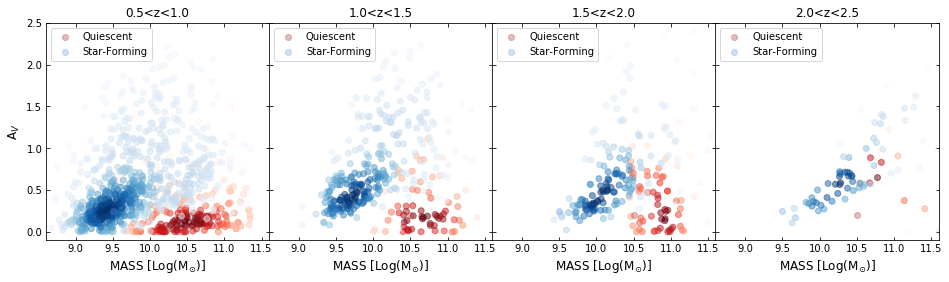

In [36]:
fig = plt.figure(figsize = (16,4))

for i in range (len(passive)):
   
    xy = np.vstack([passive[i]['LMASS'],passive[i]['AV']])
    z = gaussian_kde(xy)(xy)
    
    x_1y_1 = np.vstack([attive[i]['LMASS'],attive[i]['AV']])
    z1 = gaussian_kde(x_1y_1)(x_1y_1)
    

    
    ax = plt.subplot(1,4,i+1)
    plt.scatter(passive[i]['LMASS'], passive[i]['AV'],  c = z, cmap = 'Reds', alpha = 0.5)
    plt.scatter(10.5,0.2, c = 'firebrick', marker = 'o', alpha = 0.3, label = 'Quiescent')
    plt.scatter(attive[i]['LMASS'], attive[i]['AV'], c = z1, cmap = 'Blues', alpha = 0.5)
    plt.scatter(9.5,0.25, c = 'cornflowerblue', marker = 'o', alpha = 0.3, label = 'Star-Forming')
    plt.legend(loc = 'upper left')
    ax.set_xlabel('MASS [Log(M$_{\odot}$)]', fontsize = 12)
    
    ax.set_xlim(8.6,11.6)
    ax.set_ylim(-.1,2.5)
    ax.set_title(title[i])
    
    ax.tick_params(axis='x',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax.tick_params(axis='y',direction = 'in')#, grid_alpha=0.5, grid_linewidth = 2, grid_linestyle = ':')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    if i == 0:
        ax.set_ylabel('A$_{V}$', fontsize = 12)
    else:
        ax.set_yticklabels([])
    
    
plt.subplots_adjust(wspace =0)
#fig.savefig('avVSmass_RdBu.png')
plt.show()

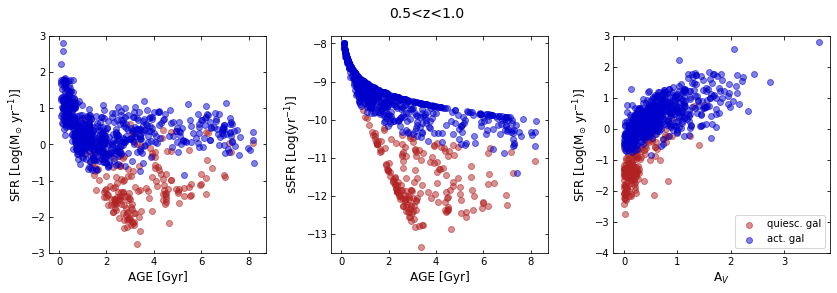

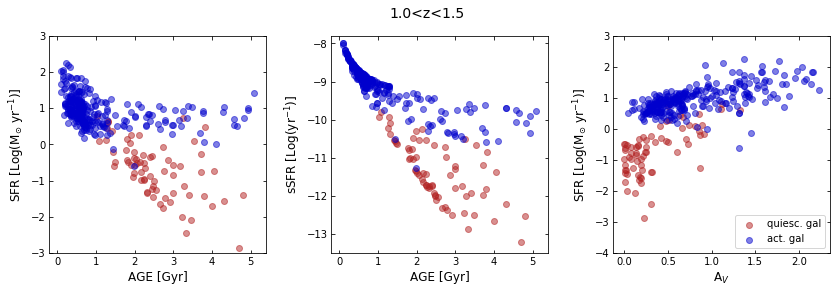

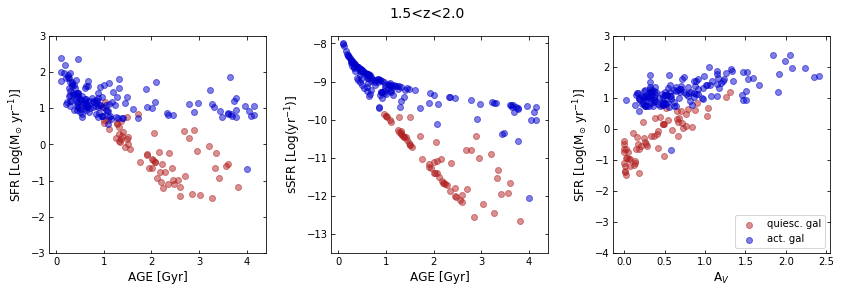

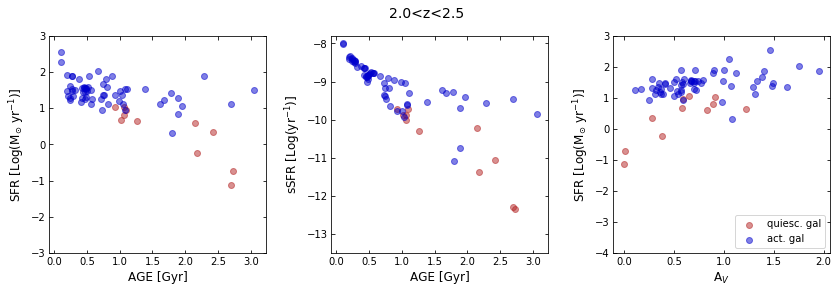

In [75]:
for i in range(4):
    fig = plt.figure(figsize = (14,4))
    
    plt.suptitle(title[i], fontsize = 14)

    
    
    
    ax0 = plt.subplot(1,3,1)
    #PLOT
    plt.scatter(passive[i]['AGE']*10**(-3), passive[i]['LSFR'], c = 'firebrick', alpha = 0.5)
    plt.scatter(attive[i]['AGE']*10**(-3), attive[i]['LSFR'], c = 'mediumblue', alpha = 0.5)
    #STYLE
    ax0.set_ylim(-3,3)
    ax0.set_xlabel('AGE [Gyr]', fontsize = 12)
    ax0.set_ylabel('SFR [Log(M$_{\odot}$ yr$^{-1})]$', fontsize = 12)
    #axis
    ax0.tick_params(axis='x',direction = 'in')
    ax0.tick_params(axis='y',direction = 'in')
    ax0.xaxis.set_ticks_position('both')
    ax0.yaxis.set_ticks_position('both')

    
    
    
    ax1 = plt.subplot(1,3,2)
    #PLOT
    plt.scatter(passive[i]['AGE']*10**(-3), passive[i]['LSFR']-passive[i]['LMASS'], c = 'firebrick', alpha = 0.5)
    plt.scatter(attive[i]['AGE']*10**(-3), attive[i]['LSFR']-attive[i]['LMASS'], c = 'mediumblue', alpha = 0.5)
    #STYLE
    ax1.set_ylim(-13.5,-7.8)
    ax1.set_xlabel('AGE [Gyr]', fontsize = 12)
    ax1.set_ylabel('sSFR [Log(yr$^{-1})]$', fontsize = 12) 
    #axis
    ax1.tick_params(axis='x',direction = 'in')
    ax1.tick_params(axis='y',direction = 'in')#, labelleft = 'off', labelright = 'on')
    #ax1.yaxis.set_label_position('right')
    #ax1.yaxis.tick_right()
    ax1.xaxis.set_ticks_position('both')
    ax1.yaxis.set_ticks_position('both')
        
    
    
    
    ax2 = plt.subplot(1,3,3)
    #PLOT
    plt.scatter(passive[i]['AV'], passive[i]['LSFR'], c = 'firebrick', alpha = 0.5, label = 'quiesc. gal') 
    plt.scatter(attive[i]['AV'], attive[i]['LSFR'], c = 'mediumblue', alpha = 0.5, label = 'act. gal')
    #STYLE
    ax2.set_ylim(-4,3)
    ax2.set_xlabel(r'A$_V$', fontsize = 12)
    ax2.set_ylabel('SFR [Log(M$_{\odot}$ yr$^{-1})]$', fontsize = 12) 
    #axis
    ax2.tick_params(axis='x',direction = 'in')
    ax2.tick_params(axis='y',direction = 'in')
    #ax2.yaxis.set_label_position('right')
    #ax2.yaxis.tick_right()
    ax2.xaxis.set_ticks_position('both')
    ax2.yaxis.set_ticks_position('both')
    ax2.legend(loc = 'lower right')
    
    
 
    plt.subplots_adjust(wspace = 0.3)
    plt.show()
    #fig.savefig('quiesc&act_parcheck'+str(title[i])+'.png')


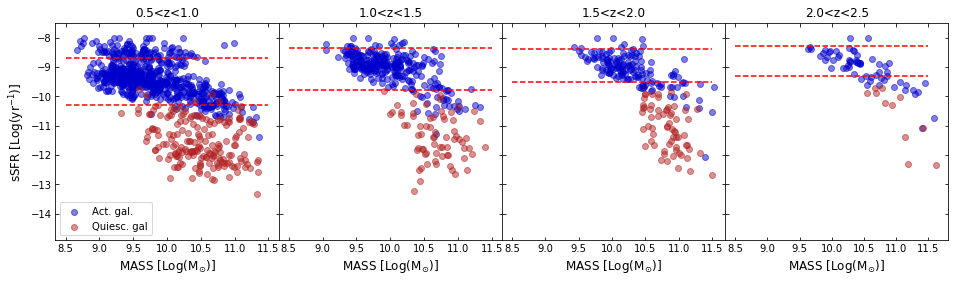

In [74]:
title = []
fig = plt.figure(figsize = (16,4))


for i in range (len(tab)):

    ax = plt.subplot(1,4,i+1)
    #SPECIFIC SFR SIAMO CON LE POTENZE!! per normalizzare devo sottrarre gli esponenti
    plt.scatter(attive[i]['LMASS'], attive[i]['LSFR']-attive[i]['LMASS'], 
                alpha = 0.5, c = 'mediumblue', label = 'Act. gal.')
    plt.scatter(passive[i]['LMASS'], passive[i]['LSFR']-passive[i]['LMASS'],
                alpha = 0.5, c = 'firebrick', label = 'Quiesc. gal')
    
    
    if i == 0:
        ax.hlines(-10.3, 8.5,11.5,ls = '--', color= 'r') #0.5<z<1.
        ax.hlines(-8.7, 8.5,11.5, ls ='--', color= 'r')
        ax.set_ylabel('sSFR [Log(yr$^{-1}$)]', fontsize = 12)
        ax.legend(loc = 'lower left')
        
    elif i == 1:
        ax.hlines(-9.8, 8.5,11.5, ls ='--', color= 'r') #1.<z<1.5
        ax.hlines(-8.35, 8.5,11.5, ls ='--', color= 'r')
        ax.set_yticklabels([])
    
    elif i == 2:
        ax.hlines(-9.5, 8.5,11.5, ls ='--', color= 'r') #1.5<z<2.
        ax.hlines(-8.4, 8.5,11.5, ls ='--', color= 'r')
        ax.set_yticklabels([])
   
    elif i == 3:
        ax.hlines(-9.3, 8.5,11.5, ls ='--', color= 'r') #2.<z<2.5
        ax.hlines(-8.3, 8.5,11.5, ls ='--', color= 'r')
        ax.set_yticklabels([])
   
    plt.xlabel('MASS [Log(M$_{\odot}$)]', fontsize = 12)
    for j in range(len(estremi)):
        if j == (len(estremi)-1):
            break
        title.append(str(estremi[j]/10)+'<z<'+str((estremi[j+1])/10))
    ax.tick_params(axis='x',direction = 'in')
    ax.tick_params(axis='y',direction = 'in')
    #ax2.yaxis.set_label_position('right')
    #ax2.yaxis.tick_right()
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(-14.9,-7.5)
    plt.title(title[i])
plt.subplots_adjust(wspace=0)
#fig.savefig('check_tagli.png')
plt.show()
plt.close()
    

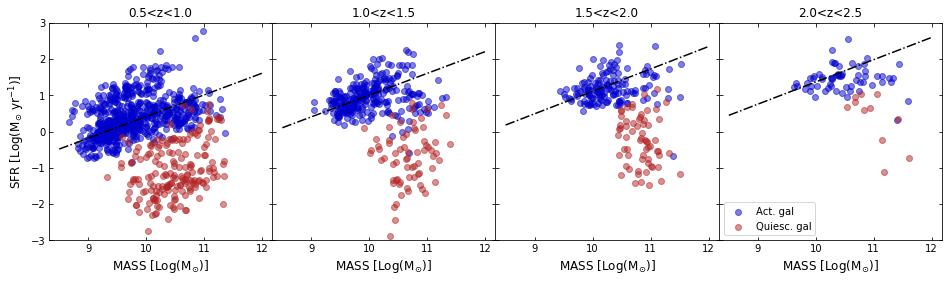

In [73]:
fig = plt.figure(figsize = (16,4))


for i in range (len(tab)):

    ax = plt.subplot(1,4,i+1)
    #SPECIFIC SFR SIAMO CON LE POTENZE!! per normalizzare devo sottrarre gli esponenti
    plt.scatter(attive[i]['LMASS'], attive[i]['LSFR'],
                alpha = 0.5, c = 'mediumblue', label = 'Act. gal' )
    plt.scatter(passive[i]['LMASS'], passive[i]['LSFR'],
                alpha = 0.5, c = 'firebrick', label = 'Quiesc. gal')
    x = np.linspace(8.5,12.,100000)
    plt.plot(x, x*slope[i][0]+slope[i][1], ls = '-.', c = 'black')


    
    if i == 0:
        ax.set_ylabel('SFR [Log(M$_{\odot}$ yr$^{-1}$)]', fontsize = 12)
        
        
    elif i == 1:
        ax.set_yticklabels([])
    
    elif i == 2:
        ax.set_yticklabels([])
   
    elif i == 3:
        ax.set_yticklabels([])
        ax.legend(loc = 'lower left')
    
    plt.xlabel('MASS [Log(M$_{\odot}$)]', fontsize = 12)
    ax.tick_params(axis='x',direction = 'in')
    ax.tick_params(axis='y',direction = 'in')
    #ax2.yaxis.set_label_position('right')
    #ax2.yaxis.tick_right()
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(-3,3)
    ax.set_title(title[i])

plt.subplots_adjust(wspace = 0)
#fig.savefig('check_mainsequence.png')
plt.show()
plt.close()
    